In [1]:
import numpy as np
import pandas as pd

| Context Source | Category | Text Memory | Vision Memory | Delta (Text - Vision) |
| :--- | :--- | :---: | :---: | :---: |
| **Text Context** | People-Location | 0.8 | 1.7 | -0.9 |
| | People-Temporal | 0 | 0 | 0 |
| | People-Career | 56.7 | 81.6 | -24.9 |
| | Logo-Time | 0 | 0 | 0 |
| | Logo-Creator | 56.9 | 61.5 | -4.6 |
| | Logo-Content | 72.6 | 87.8 | -15.2 |
| **Vision Context** | People-Location | 5.9 | 4.2 | 1.7 |
| | People-Temporal | 0 | 0 | 0 |
| | People-Career | 84.4 | 83.0 | 1.4 |
| | Logo-Time | 4.8 | 4.8 | 0 |
| | Logo-Creator | 73.8 | 72.3 | 1.5 |
| | Logo-Content | 95.9 | 95.9 | 0 |

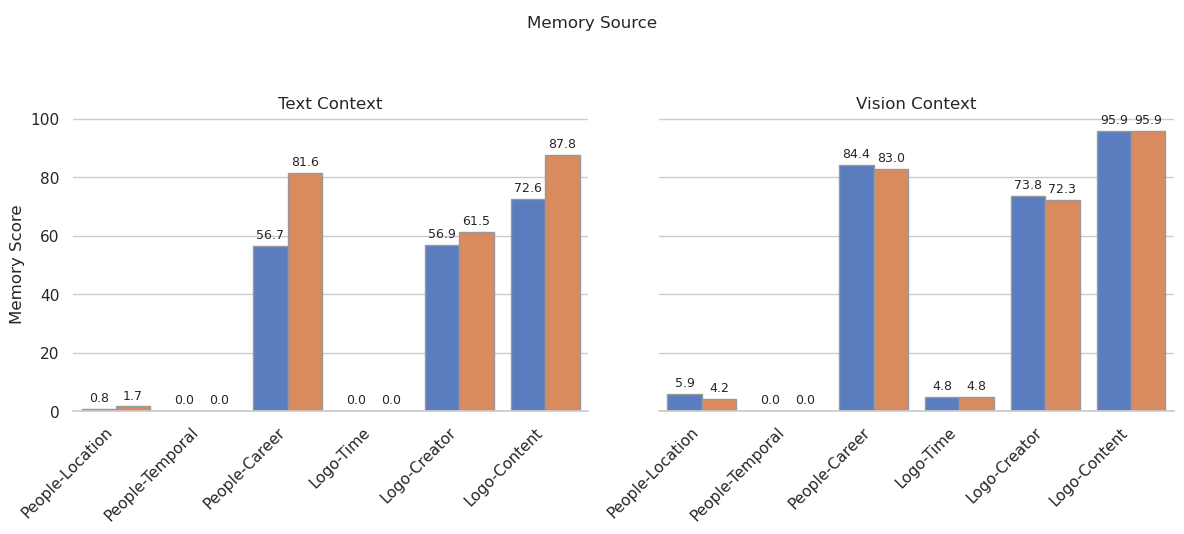

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = [
    {'Context': 'Text Context', 'Category': 'People-Location', 'Text Memory': 0.8, 'Vision Memory': 1.7},
    {'Context': 'Text Context', 'Category': 'People-Temporal', 'Text Memory': 0, 'Vision Memory': 0},
    {'Context': 'Text Context', 'Category': 'People-Career', 'Text Memory': 56.7, 'Vision Memory': 81.6},
    {'Context': 'Text Context', 'Category': 'Logo-Time', 'Text Memory': 0, 'Vision Memory': 0},
    {'Context': 'Text Context', 'Category': 'Logo-Creator', 'Text Memory': 56.9, 'Vision Memory': 61.5},
    {'Context': 'Text Context', 'Category': 'Logo-Content', 'Text Memory': 72.6, 'Vision Memory': 87.8},
    {'Context': 'Vision Context', 'Category': 'People-Location', 'Text Memory': 5.9, 'Vision Memory': 4.2},
    {'Context': 'Vision Context', 'Category': 'People-Temporal', 'Text Memory': 0, 'Vision Memory': 0},
    {'Context': 'Vision Context', 'Category': 'People-Career', 'Text Memory': 84.4, 'Vision Memory': 83.0},
    {'Context': 'Vision Context', 'Category': 'Logo-Time', 'Text Memory': 4.8, 'Vision Memory': 4.8},
    {'Context': 'Vision Context', 'Category': 'Logo-Creator', 'Text Memory': 73.8, 'Vision Memory': 72.3},
    {'Context': 'Vision Context', 'Category': 'Logo-Content', 'Text Memory': 95.9, 'Vision Memory': 95.9}
]

df = pd.DataFrame(data)
df_melted = df.melt(id_vars=['Context', 'Category'], value_vars=['Text Memory', 'Vision Memory'], var_name='Memory Type', value_name='Score')

sns.set_theme(style="whitegrid")

# Create plot, turn off default legend
g = sns.catplot(
    data=df_melted, 
    kind="bar",
    x="Category", 
    y="Score", 
    hue="Memory Type", 
    col="Context",
    height=5, 
    aspect=1.2,
    palette="muted",
    edgecolor=".6",
    legend=False
)

g.despine(left=True)
g.set_axis_labels("", "Memory Score")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45, ha='right')

# Add bar labels
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f', padding=3, fontsize=9)

# Get handles and labels from one of the axes to build the global legend
handles, labels = g.axes[0][0].get_legend_handles_labels()

# Place legend on the Figure object
g.fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=2, frameon=False, title="Memory Source")

# Adjust top margin to make room for the legend
plt.tight_layout()
plt.subplots_adjust(top=0.85)

plt.show()

# Benchmarking knowledge about celebrities

## Get Rid of celebrities the model cannot recognize

In [2]:
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/WHO_VISION_Experiment_Results.csv")
df['Knows_celeb'] = df.apply(lambda row: row['Instance'] in row['Response'], axis=1)

In [3]:
unknown_celebs = df[df["Knows_celeb"] == False]['Instance'].unique() 
unknown_celebs = unknown_celebs[1:] # "Remove The Rock from unknown list bc it knows Dwayne Johnson"
unknown_celebs

array(['Post Malone', 'Natalie Portman', 'Jet Li', 'John Green', 'Eminem',
       'Travis Scott', 'Megan Thee Stallion', 'J Balvin'], dtype=object)

## Find rows which the model answer correct using parametric vision and language knowledge

In [4]:
df_inherent_text = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/No_RAG_Experiment_Results.csv")
df_inherent_vision = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/No_RAG_VISION_Experiment_Results.csv")
df_inherent_text

def get_correct_indices(df):
    # 1. Define the probability columns
    prob_cols = ['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']
    
    # 2. Find the column name with the max value for each row (e.g., "Prob_A")
    # idxmax(axis=1) returns the column label of the maximum value
    predicted_col = df[prob_cols].idxmax(axis=1)
    
    # 3. Clean the prediction to match Ground_Truth format (e.g., "Prob_A" -> "A")
    predicted_choice = predicted_col.str.replace('Prob_', '')
    
    # 4. Compare with Ground Truth
    # We strip whitespace from both just to be safe (e.g. " A" vs "A")
    is_correct = predicted_choice.str.strip() == df['Ground_Truth'].str.strip()
    
    return is_correct

# Get the boolean mask (True/False) for both dataframes
text_correct_mask = get_correct_indices(df_inherent_text)
vision_correct_mask = get_correct_indices(df_inherent_vision)

# Find where BOTH are True
# We use the bitwise AND operator '&'
both_correct_mask = text_correct_mask & vision_correct_mask

# Extract the actual indices
correct_indices = df_inherent_text.index[both_correct_mask].tolist()

print(f"Number of matches: {len(correct_indices)}")
print("Indices:", correct_indices)

Number of matches: 297
Indices: [0, 1, 2, 4, 5, 8, 10, 11, 13, 14, 16, 17, 19, 20, 22, 23, 25, 26, 28, 29, 31, 32, 35, 37, 38, 39, 40, 41, 43, 44, 46, 47, 48, 49, 50, 52, 53, 56, 58, 59, 61, 62, 64, 65, 67, 68, 69, 70, 71, 73, 74, 77, 80, 82, 83, 85, 86, 88, 89, 90, 91, 92, 94, 95, 98, 100, 101, 102, 103, 104, 105, 107, 110, 113, 115, 116, 119, 121, 122, 124, 125, 127, 128, 130, 131, 133, 134, 135, 136, 137, 139, 140, 142, 143, 145, 146, 148, 149, 150, 152, 154, 155, 157, 158, 160, 161, 163, 164, 167, 168, 170, 171, 172, 173, 175, 176, 178, 179, 181, 182, 185, 187, 188, 190, 191, 193, 194, 196, 197, 199, 200, 202, 203, 205, 206, 208, 209, 211, 212, 213, 214, 215, 217, 218, 220, 221, 223, 224, 226, 227, 229, 230, 231, 232, 233, 235, 236, 238, 239, 240, 241, 242, 245, 247, 248, 251, 253, 254, 256, 257, 259, 260, 261, 262, 263, 265, 266, 268, 269, 271, 272, 274, 275, 276, 277, 278, 280, 281, 284, 286, 287, 289, 290, 292, 293, 294, 296, 299, 301, 302, 304, 305, 306, 307, 308, 310, 311, 313

## Visualization and Analysis

In [5]:
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/RAG_Experiment_Results.csv")
df = df.iloc[correct_indices]
df = df[~df['Instance'].isin(unknown_celebs)]
df

,ID,Instance,Category,Mis_Knowledge_Key,Context,Query,Response,Prob_A,Prob_B,Prob_C,Prob_D,Ground_Truth,Mis_Answer_Label
0,1,Taylor Swift,Temporal_error,mis_knowledge1,"Taylor Swift was born on December 13, 1988. Ta...",What year was the entity born? Answers: A) 198...,system\nYou are a helpful assistant.\nuser\nCo...,0.979980,0.014420,0.001439,0.004330,C,A
1,1,Taylor Swift,location_error,mis_knowledge1,"Taylor Swift was born on December 13, 1989. Ta...",What is the nationality of the entity? Answers...,system\nYou are a helpful assistant.\nuser\nCo...,0.000335,0.999023,0.000392,0.000291,D,B
2,1,Taylor Swift,Career_error,mis_knowledge1,"Taylor Swift was born on December 13, 1989. Ta...",What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nCo...,0.081421,0.917480,0.000637,0.000238,A,B
4,2,Elon Musk,location_error,mis_knowledge1,"Elon Musk was born on June 28, 1971. Elon Musk...",What is the nationality of the entity? Answers...,system\nYou are a helpful assistant.\nuser\nCo...,0.001334,0.000317,0.998047,0.000506,A,C
5,2,Elon Musk,Career_error,mis_knowledge1,"Elon Musk was born on June 28, 1971. Elon Musk...",What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nCo...,0.000180,0.000364,0.086304,0.913086,D,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,147,Shia LaBeouf,Career_error,mis_knowledge1,"Shia LaBeouf was born on June 11, 1986. Shia L...",What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nCo...,0.983398,0.016647,0.000055,0.000100,A,B
442,148,Chadwick Boseman,location_error,mis_knowledge1,"Chadwick Boseman was born on November 29, 1976...",What is the nationality of the entity? Answers...,system\nYou are a helpful assistant.\nuser\nCo...,0.000596,0.000505,0.995605,0.003120,D,C
443,148,Chadwick Boseman,Career_error,mis_knowledge1,"Chadwick Boseman was born on November 29, 1976...",What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nCo...,0.001373,0.885254,0.112549,0.001013,C,B
445,149,Lupita Nyong'o,location_error,mis_knowledge1,"Lupita Nyong'o was born on March 1, 1983. Lupi...",What is the nationality of the entity? Answers...,system\nYou are a helpful assistant.\nuser\nCo...,0.999023,0.000869,0.000022,0.000046,B,A


In [6]:
df['Category'].value_counts()

Category
Career_error      141
location_error    119
Temporal_error     23
Name: count, dtype: int64

Overall Accuracy: 28.62%
Category
Career_error      56.737589
Temporal_error     0.000000
location_error     0.840336
Name: Is_Correct, dtype: float64


/tmp/ipykernel_2250032/3291027162.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')


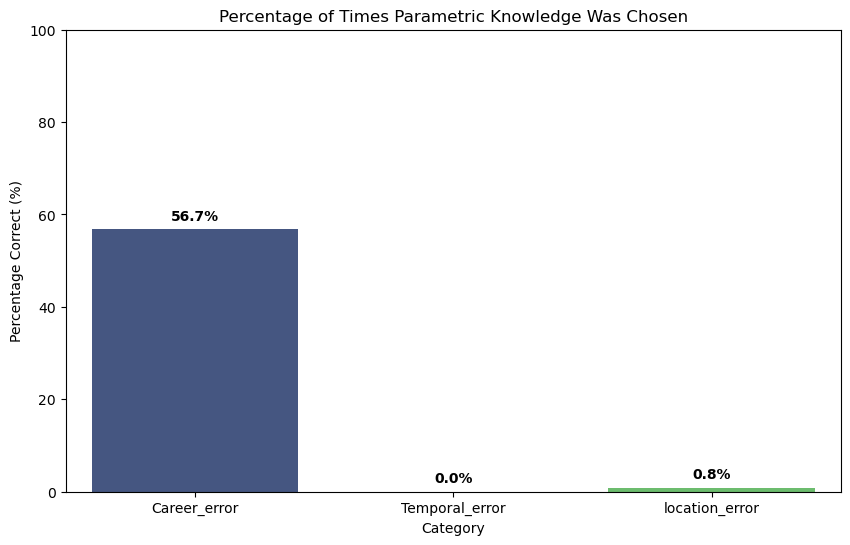

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

probs = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].values
df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']] = probs / probs.sum(axis=1, keepdims=True)

# ---------------------------------------------------------
# ANALYSIS CODE START
# ---------------------------------------------------------

# 1. Determine the model's chosen answer (highest probability)
# idxmax returns the column name (e.g., "Prob_A"). We strip "Prob_" to get "A".
df['Predicted_Choice'] = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].idxmax(axis=1).apply(lambda x: x.split('_')[1])

# 2. Check if it matches Ground Truth
df['Is_Correct'] = df['Predicted_Choice'] == df['Ground_Truth']

# 3. Calculate Percentage
overall_accuracy = df['Is_Correct'].mean() * 100
accuracy_by_category = df.groupby('Category')['Is_Correct'].mean() * 100

print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(accuracy_by_category)

# 4. Visualization
plt.figure(figsize=(10, 6))

# We can plot accuracy by category
sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')

plt.ylabel('Percentage Correct (%)')
plt.xlabel('Category')
plt.title('Percentage of Times Parametric Knowledge Was Chosen')
plt.ylim(0, 100)

# Add text labels on bars
for i, v in enumerate(accuracy_by_category.values):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()

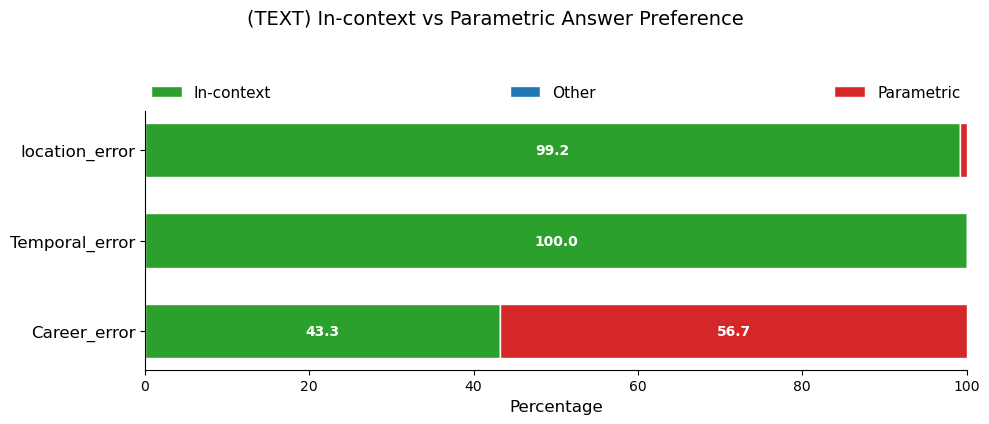

In [8]:
def classify_outcome(row):
    # Clean whitespace just in case (e.g., " A" vs "A")
    pred = str(row['Predicted_Choice'])
    gt = str(row['Ground_Truth'])
    mis = str(row['Mis_Answer_Label'])
    
    if pred == gt:
        return "Parametric"
    elif pred == mis:
        return "In-context"
    else:
        return "Other"

df['Outcome'] = df.apply(classify_outcome, axis=1)

group_col = 'Category' # Change to 'Model' if you have a model column
outcome_counts = df.groupby([group_col, 'Outcome']).size().unstack(fill_value=0)

# Calculate percentages
outcome_pct = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100

# Ensure all columns exist (in case one category has 0 "Other")
for col in ['In-context', 'Parametric', 'Other']:
    if col not in outcome_pct.columns:
        outcome_pct[col] = 0

# Reorder columns to match the visual preference
# (e.g., In-context (Left), Parametric (Middle/Right), Other (Right))
outcome_pct = outcome_pct[['In-context', 'Other', 'Parametric']]


# ---------------------------------------------------------
# 4. Plotting
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 4))

# Define Colors matching the vibe of the reference
# Reference: Knowledge(Red), Other(Blue), Vision(Green)
# Your mapping: In-context (GT), Parametric (Mis), Other
colors = {
    'In-context': '#2ca02c',  # Green (Success/Ground Truth)
    'Other': '#1f77b4',       # Blue
    'Parametric': '#d62728'   # Red (Conflict/Mis-knowledge)
}
# Or if you want to strictly match the reference image's color-to-concept mapping:
# colors = {'In-context': '#d62728', 'Other': '#1f77b4', 'Parametric': '#2ca02c'}

# Stacked Bar Plot
y_pos = np.arange(len(outcome_pct))
height = 0.6

left_offset = np.zeros(len(outcome_pct))

categories = outcome_pct.columns # ['In-context', 'Other', 'Parametric']

for cat in categories:
    values = outcome_pct[cat].values
    ax.barh(y_pos, values, height, left=left_offset, color=colors[cat], label=cat, edgecolor='white')
    
    # Add percentage text inside bars
    for i, (val, left) in enumerate(zip(values, left_offset)):
        if val > 5: # Only show text if the bar is wide enough
            # Text color logic: white for dark bars
            ax.text(left + val/2, i, f'{val:.1f}', 
                    ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    
    left_offset += values

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(outcome_pct.index, fontsize=12)
ax.set_xlim(0, 100)
ax.set_xlabel('Percentage', fontsize=12)

# Move Legend to top (like the reference)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0., frameon=False, fontsize=11)

# Remove top and right spines for cleanliness
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.suptitle(
    "(TEXT) In-context vs Parametric Answer Preference",
    fontsize=14,
    y=1.05  # adjust vertical position
)

plt.tight_layout()
plt.show()

In [9]:
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/No_RAG_Experiment_Results.csv")
df = df[~df['Instance'].isin(unknown_celebs)]
print(df['Response'].iloc[25])

system
You are a helpful assistant.
user
Given your knowledge, answer the multiple choice question about the following entity.
Entity: Tom Hanks.
Query: What is the nationality of the entity? Answers: A) Canadian B) American C) Mexican D) Panamanian
assistant
Between A, B, C, and D, the answer is  B) American. Tom Hanks is an American actor and filmmaker.


Overall Accuracy: 72.81%
Category
Career_error      100.000000
Temporal_error     28.368794
location_error     90.070922
Name: Is_Correct, dtype: float64


/tmp/ipykernel_2250032/3089483106.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')


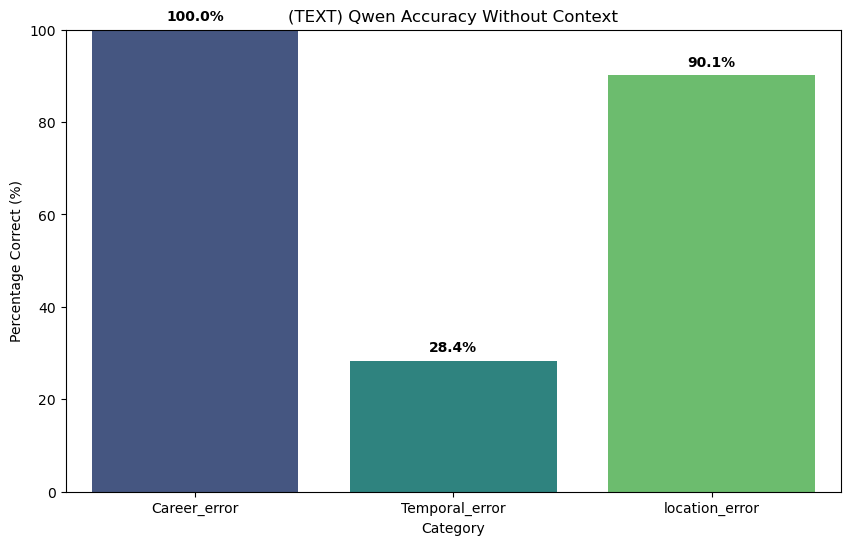

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

probs = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].values
df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']] = probs / probs.sum(axis=1, keepdims=True)

# ---------------------------------------------------------
# ANALYSIS CODE START
# ---------------------------------------------------------

# 1. Determine the model's chosen answer (highest probability)
# idxmax returns the column name (e.g., "Prob_A"). We strip "Prob_" to get "A".
df['Predicted_Choice'] = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].idxmax(axis=1).apply(lambda x: x.split('_')[1])

# 2. Check if it matches Ground Truth
df['Is_Correct'] = df['Predicted_Choice'] == df['Ground_Truth']

# 3. Calculate Percentage
overall_accuracy = df['Is_Correct'].mean() * 100
accuracy_by_category = df.groupby('Category')['Is_Correct'].mean() * 100

print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(accuracy_by_category)

# 4. Visualization
plt.figure(figsize=(10, 6))

# We can plot accuracy by category
sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')

plt.ylabel('Percentage Correct (%)')
plt.xlabel('Category')
plt.title('(TEXT) Qwen Accuracy Without Context')
plt.ylim(0, 100)

# Add text labels on bars
for i, v in enumerate(accuracy_by_category.values):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()

In [11]:
split_func = lambda x: x.split('Between A, B, C, and D, the answer is  ')[-1][0]
df['str_resp'] = df['Response'].apply(split_func)
(df['str_resp'] == df['Predicted_Choice'])

0      False
1       True
2       True
3      False
4       True
       ...  
442     True
443     True
444    False
445     True
446     True
Length: 423, dtype: bool

In [12]:
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/RAG_VISION_Experiment_Results.csv")
df = df.iloc[correct_indices]
df = df[~df['Instance'].isin(unknown_celebs)]
print(df['Response'].iloc[25])

system
You are a helpful assistant.
user
Context information is below.
---------------------
Bill Gates was born on October 28, 1956. Bill Gates is American. Bill Gates is a business magnate, software developer, and philanthropist.
---------------------
Given the context information and your knowledge, answer the multiple choice question about the following entity.
Entity: 
Query: What year was the entity born? Answers: A) 1955 B) 1956 C) 1954 D) 1957
assistant
Between A, B, C, and D, the answer is 1956.


Overall Accuracy: 41.34%
Category
Career_error      81.560284
Temporal_error     0.000000
location_error     1.680672
Name: Is_Correct, dtype: float64


/tmp/ipykernel_2250032/311489245.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')


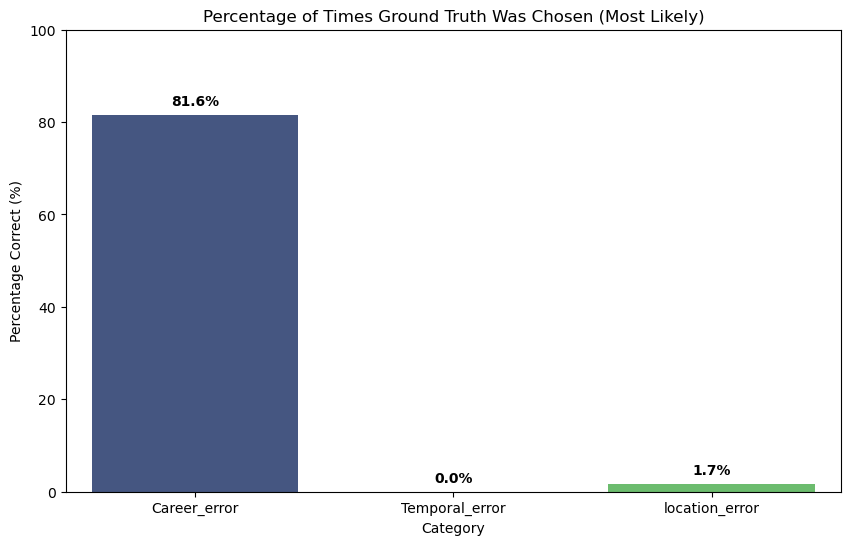

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

probs = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].values
df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']] = probs / probs.sum(axis=1, keepdims=True)

# ---------------------------------------------------------
# ANALYSIS CODE START
# ---------------------------------------------------------

# 1. Determine the model's chosen answer (highest probability)
# idxmax returns the column name (e.g., "Prob_A"). We strip "Prob_" to get "A".
df['Predicted_Choice'] = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].idxmax(axis=1).apply(lambda x: x.split('_')[1])

# 2. Check if it matches Ground Truth
df['Is_Correct'] = df['Predicted_Choice'] == df['Ground_Truth']

# 3. Calculate Percentage
overall_accuracy = df['Is_Correct'].mean() * 100
accuracy_by_category = df.groupby('Category')['Is_Correct'].mean() * 100

print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(accuracy_by_category)

# 4. Visualization
plt.figure(figsize=(10, 6))

# We can plot accuracy by category
sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')

plt.ylabel('Percentage Correct (%)')
plt.xlabel('Category')
plt.title('Percentage of Times Ground Truth Was Chosen (Most Likely)')
plt.ylim(0, 100)

# Add text labels on bars
for i, v in enumerate(accuracy_by_category.values):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()

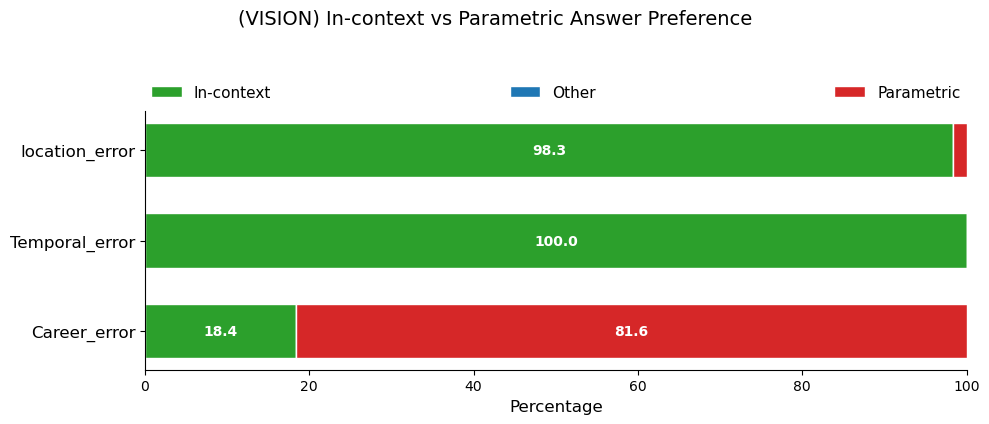

In [14]:
def classify_outcome(row):
    # Clean whitespace just in case (e.g., " A" vs "A")
    pred = str(row['Predicted_Choice'])
    gt = str(row['Ground_Truth'])
    mis = str(row['Mis_Answer_Label'])
    
    if pred == gt:
        return "Parametric"
    elif pred == mis:
        return "In-context"
    else:
        return "Other"

df['Outcome'] = df.apply(classify_outcome, axis=1)

group_col = 'Category' # Change to 'Model' if you have a model column
outcome_counts = df.groupby([group_col, 'Outcome']).size().unstack(fill_value=0)

# Calculate percentages
outcome_pct = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100

# Ensure all columns exist (in case one category has 0 "Other")
for col in ['In-context', 'Parametric', 'Other']:
    if col not in outcome_pct.columns:
        outcome_pct[col] = 0

# Reorder columns to match the visual preference
# (e.g., In-context (Left), Parametric (Middle/Right), Other (Right))
outcome_pct = outcome_pct[['In-context', 'Other', 'Parametric']]


# ---------------------------------------------------------
# 4. Plotting
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 4))

# Define Colors matching the vibe of the reference
# Reference: Knowledge(Red), Other(Blue), Vision(Green)
# Your mapping: In-context (GT), Parametric (Mis), Other
colors = {
    'In-context': '#2ca02c',  # Green (Success/Ground Truth)
    'Other': '#1f77b4',       # Blue
    'Parametric': '#d62728'   # Red (Conflict/Mis-knowledge)
}
# Or if you want to strictly match the reference image's color-to-concept mapping:
# colors = {'In-context': '#d62728', 'Other': '#1f77b4', 'Parametric': '#2ca02c'}

# Stacked Bar Plot
y_pos = np.arange(len(outcome_pct))
height = 0.6

left_offset = np.zeros(len(outcome_pct))

categories = outcome_pct.columns # ['In-context', 'Other', 'Parametric']

for cat in categories:
    values = outcome_pct[cat].values
    ax.barh(y_pos, values, height, left=left_offset, color=colors[cat], label=cat, edgecolor='white')
    
    # Add percentage text inside bars
    for i, (val, left) in enumerate(zip(values, left_offset)):
        if val > 5: # Only show text if the bar is wide enough
            # Text color logic: white for dark bars
            ax.text(left + val/2, i, f'{val:.1f}', 
                    ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    
    left_offset += values

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(outcome_pct.index, fontsize=12)
ax.set_xlim(0, 100)
ax.set_xlabel('Percentage', fontsize=12)

# Move Legend to top (like the reference)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0., frameon=False, fontsize=11)

# Remove top and right spines for cleanliness
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.suptitle(
    "(VISION) In-context vs Parametric Answer Preference",
    fontsize=14,
    y=1.05  # adjust vertical position
)

plt.tight_layout()
plt.show()

In [15]:
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/No_RAG_VISION_Experiment_Results.csv")
df = df[~df['Instance'].isin(unknown_celebs)]
print(df['Response'].iloc[27])

system
You are a helpful assistant.
user
Given your knowledge, answer the multiple choice question about the following entity.
Entity: 
Query: What year was the entity born? Answers: A) 1969 B) 1966 C) 1970 D) 1968
assistant
Between A, B, C, and D, the answer is 1970.


Overall Accuracy: 70.69%
Category
Career_error      100.000000
Temporal_error     24.822695
location_error     87.234043
Name: Is_Correct, dtype: float64


/tmp/ipykernel_2250032/3457152067.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')


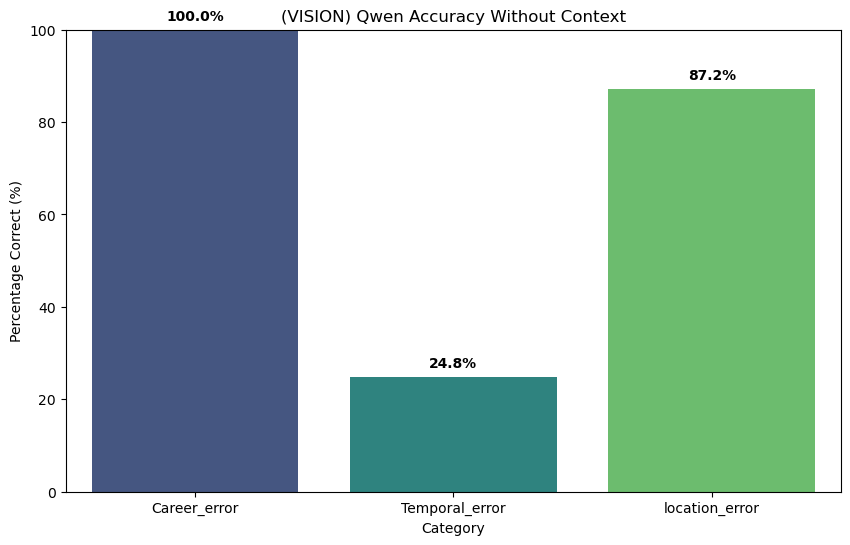

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

probs = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].values
df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']] = probs / probs.sum(axis=1, keepdims=True)

# ---------------------------------------------------------
# ANALYSIS CODE START
# ---------------------------------------------------------

# 1. Determine the model's chosen answer (highest probability)
# idxmax returns the column name (e.g., "Prob_A"). We strip "Prob_" to get "A".
df['Predicted_Choice'] = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].idxmax(axis=1).apply(lambda x: x.split('_')[1])

# 2. Check if it matches Ground Truth
df['Is_Correct'] = df['Predicted_Choice'] == df['Ground_Truth']

# 3. Calculate Percentage
overall_accuracy = df['Is_Correct'].mean() * 100
accuracy_by_category = df.groupby('Category')['Is_Correct'].mean() * 100

print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(accuracy_by_category)

# 4. Visualization
plt.figure(figsize=(10, 6))

# We can plot accuracy by category
sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')

plt.ylabel('Percentage Correct (%)')
plt.xlabel('Category')
plt.title('(VISION) Qwen Accuracy Without Context')
plt.ylim(0, 100)

# Add text labels on bars
for i, v in enumerate(accuracy_by_category.values):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()

## Vision vs Language with Image context

In [17]:
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Image_RAG_Experiment_Results.csv")
df = df.iloc[correct_indices]
df = df[~df['Instance'].isin(unknown_celebs)]
df

,ID,Instance,Category,Mis_Knowledge_Key,Context,Query,Response,Prob_A,Prob_B,Prob_C,Prob_D,Ground_Truth,Mis_Answer_Label
0,1,Taylor Swift,Temporal_error,mis_knowledge1,"The person pictured was born on December 13, 1...",What year was the entity born? Answers: A) 198...,system\nYou are a helpful assistant.\nuser\nCo...,0.985352,0.010948,0.001349,0.002241,C,A
1,1,Taylor Swift,location_error,mis_knowledge1,"The person pictured was born on December 13, 1...",What is the nationality of the entity? Answers...,system\nYou are a helpful assistant.\nuser\nCo...,0.000278,0.999023,0.000310,0.000462,D,B
2,1,Taylor Swift,Career_error,mis_knowledge1,"The person pictured was born on December 13, 1...",What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nCo...,0.762695,0.236328,0.000550,0.000329,A,B
4,2,Elon Musk,location_error,mis_knowledge1,"The person pictured was born on June 28, 1971....",What is the nationality of the entity? Answers...,system\nYou are a helpful assistant.\nuser\nCo...,0.001512,0.000401,0.997559,0.000288,A,C
5,2,Elon Musk,Career_error,mis_knowledge1,"The person pictured was born on June 28, 1971....",What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nCo...,0.000129,0.000401,0.001477,0.998047,D,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,147,Shia LaBeouf,Career_error,mis_knowledge1,"The person pictured was born on June 11, 1986....",What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nCo...,0.988281,0.011688,0.000055,0.000108,A,B
442,148,Chadwick Boseman,location_error,mis_knowledge1,"The person pictured was born on November 29, 1...",What is the nationality of the entity? Answers...,system\nYou are a helpful assistant.\nuser\nCo...,0.000669,0.000718,0.995605,0.002796,D,C
443,148,Chadwick Boseman,Career_error,mis_knowledge1,"The person pictured was born on November 29, 1...",What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nCo...,0.002642,0.047913,0.947754,0.001887,C,B
445,149,Lupita Nyong'o,location_error,mis_knowledge1,"The person pictured was born on March 1, 1983....",What is the nationality of the entity? Answers...,system\nYou are a helpful assistant.\nuser\nCo...,0.998047,0.002066,0.000052,0.000057,B,A


Overall Accuracy: 44.52%
Category
Career_error      84.397163
Temporal_error     0.000000
location_error     5.882353
Name: Is_Correct, dtype: float64


/tmp/ipykernel_2250032/311489245.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')


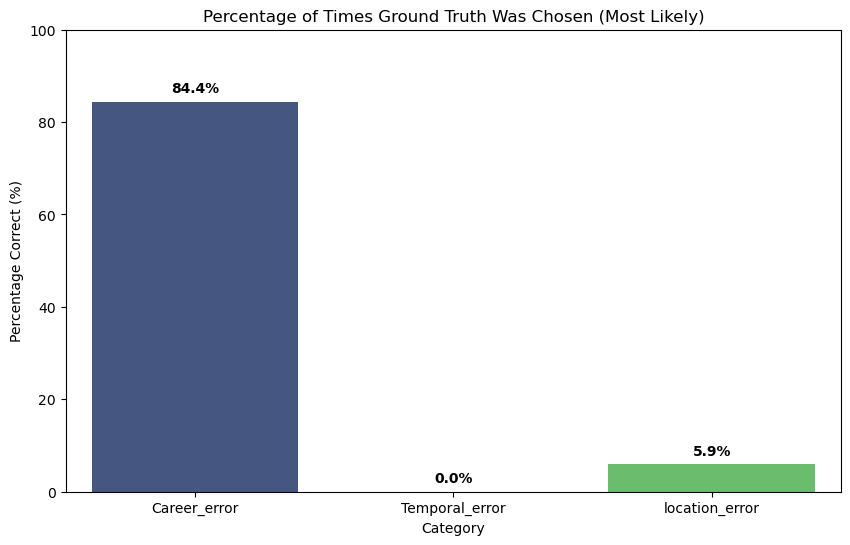

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

probs = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].values
df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']] = probs / probs.sum(axis=1, keepdims=True)

# ---------------------------------------------------------
# ANALYSIS CODE START
# ---------------------------------------------------------

# 1. Determine the model's chosen answer (highest probability)
# idxmax returns the column name (e.g., "Prob_A"). We strip "Prob_" to get "A".
df['Predicted_Choice'] = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].idxmax(axis=1).apply(lambda x: x.split('_')[1])

# 2. Check if it matches Ground Truth
df['Is_Correct'] = df['Predicted_Choice'] == df['Ground_Truth']

# 3. Calculate Percentage
overall_accuracy = df['Is_Correct'].mean() * 100
accuracy_by_category = df.groupby('Category')['Is_Correct'].mean() * 100

print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(accuracy_by_category)

# 4. Visualization
plt.figure(figsize=(10, 6))

# We can plot accuracy by category
sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')

plt.ylabel('Percentage Correct (%)')
plt.xlabel('Category')
plt.title('Percentage of Times Ground Truth Was Chosen (Most Likely)')
plt.ylim(0, 100)

# Add text labels on bars
for i, v in enumerate(accuracy_by_category.values):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()

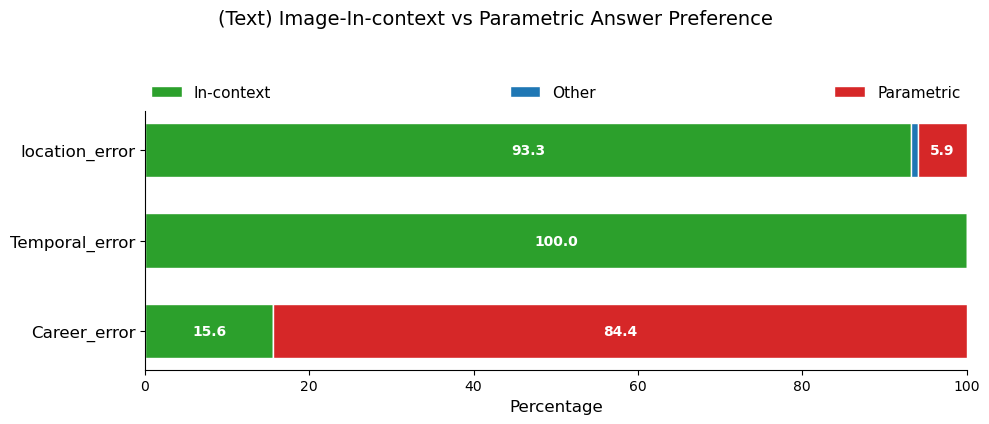

In [20]:
def classify_outcome(row):
    # Clean whitespace just in case (e.g., " A" vs "A")
    pred = str(row['Predicted_Choice'])
    gt = str(row['Ground_Truth'])
    mis = str(row['Mis_Answer_Label'])
    
    if pred == gt:
        return "Parametric"
    elif pred == mis:
        return "In-context"
    else:
        return "Other"

df['Outcome'] = df.apply(classify_outcome, axis=1)

group_col = 'Category' # Change to 'Model' if you have a model column
outcome_counts = df.groupby([group_col, 'Outcome']).size().unstack(fill_value=0)

# Calculate percentages
outcome_pct = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100

# Ensure all columns exist (in case one category has 0 "Other")
for col in ['In-context', 'Parametric', 'Other']:
    if col not in outcome_pct.columns:
        outcome_pct[col] = 0

# Reorder columns to match the visual preference
# (e.g., In-context (Left), Parametric (Middle/Right), Other (Right))
outcome_pct = outcome_pct[['In-context', 'Other', 'Parametric']]


# ---------------------------------------------------------
# 4. Plotting
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 4))

# Define Colors matching the vibe of the reference
# Reference: Knowledge(Red), Other(Blue), Vision(Green)
# Your mapping: In-context (GT), Parametric (Mis), Other
colors = {
    'In-context': '#2ca02c',  # Green (Success/Ground Truth)
    'Other': '#1f77b4',       # Blue
    'Parametric': '#d62728'   # Red (Conflict/Mis-knowledge)
}
# Or if you want to strictly match the reference image's color-to-concept mapping:
# colors = {'In-context': '#d62728', 'Other': '#1f77b4', 'Parametric': '#2ca02c'}

# Stacked Bar Plot
y_pos = np.arange(len(outcome_pct))
height = 0.6

left_offset = np.zeros(len(outcome_pct))

categories = outcome_pct.columns # ['In-context', 'Other', 'Parametric']

for cat in categories:
    values = outcome_pct[cat].values
    ax.barh(y_pos, values, height, left=left_offset, color=colors[cat], label=cat, edgecolor='white')
    
    # Add percentage text inside bars
    for i, (val, left) in enumerate(zip(values, left_offset)):
        if val > 5: # Only show text if the bar is wide enough
            # Text color logic: white for dark bars
            ax.text(left + val/2, i, f'{val:.1f}', 
                    ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    
    left_offset += values

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(outcome_pct.index, fontsize=12)
ax.set_xlim(0, 100)
ax.set_xlabel('Percentage', fontsize=12)

# Move Legend to top (like the reference)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0., frameon=False, fontsize=11)

# Remove top and right spines for cleanliness
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.suptitle(
    "(Text) Image-In-context vs Parametric Answer Preference",
    fontsize=14,
    y=1.05  # adjust vertical position
)

plt.tight_layout()
plt.show()

In [22]:
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Image_RAG_VISION_Experiment_Results.csv")
df = df.iloc[correct_indices]
df = df[~df['Instance'].isin(unknown_celebs)]
#df

Overall Accuracy: 43.11%
Category
Career_error      82.978723
Temporal_error     0.000000
location_error     4.201681
Name: Is_Correct, dtype: float64


/tmp/ipykernel_2250032/311489245.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')


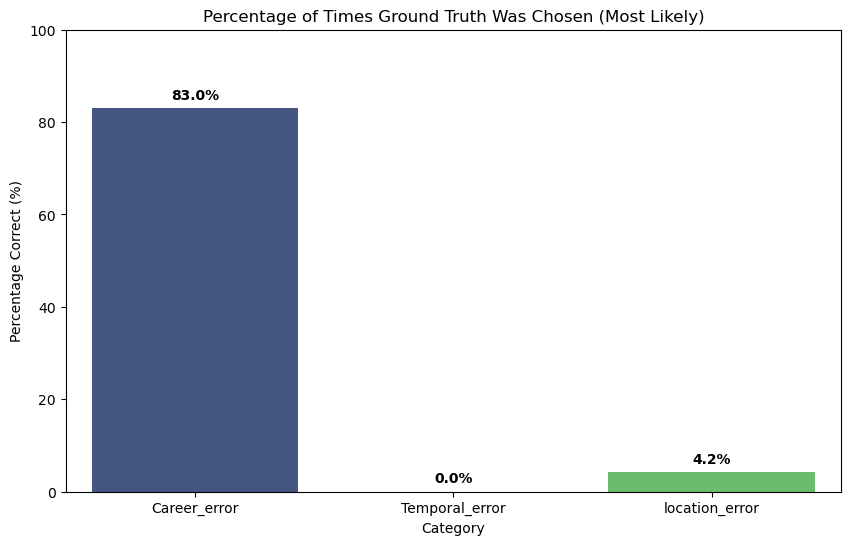

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

probs = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].values
df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']] = probs / probs.sum(axis=1, keepdims=True)

# ---------------------------------------------------------
# ANALYSIS CODE START
# ---------------------------------------------------------

# 1. Determine the model's chosen answer (highest probability)
# idxmax returns the column name (e.g., "Prob_A"). We strip "Prob_" to get "A".
df['Predicted_Choice'] = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].idxmax(axis=1).apply(lambda x: x.split('_')[1])

# 2. Check if it matches Ground Truth
df['Is_Correct'] = df['Predicted_Choice'] == df['Ground_Truth']

# 3. Calculate Percentage
overall_accuracy = df['Is_Correct'].mean() * 100
accuracy_by_category = df.groupby('Category')['Is_Correct'].mean() * 100

print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(accuracy_by_category)

# 4. Visualization
plt.figure(figsize=(10, 6))

# We can plot accuracy by category
sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')

plt.ylabel('Percentage Correct (%)')
plt.xlabel('Category')
plt.title('Percentage of Times Ground Truth Was Chosen (Most Likely)')
plt.ylim(0, 100)

# Add text labels on bars
for i, v in enumerate(accuracy_by_category.values):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()

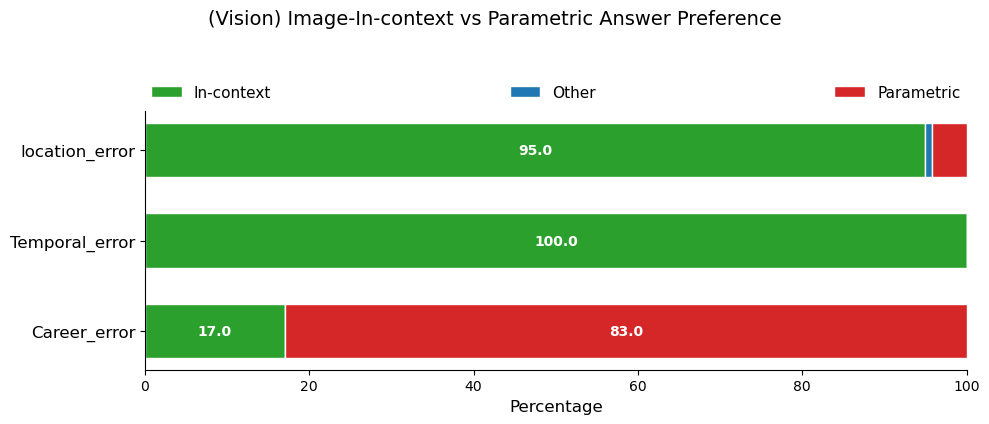

In [25]:
def classify_outcome(row):
    # Clean whitespace just in case (e.g., " A" vs "A")
    pred = str(row['Predicted_Choice'])
    gt = str(row['Ground_Truth'])
    mis = str(row['Mis_Answer_Label'])
    
    if pred == gt:
        return "Parametric"
    elif pred == mis:
        return "In-context"
    else:
        return "Other"

df['Outcome'] = df.apply(classify_outcome, axis=1)

group_col = 'Category' # Change to 'Model' if you have a model column
outcome_counts = df.groupby([group_col, 'Outcome']).size().unstack(fill_value=0)

# Calculate percentages
outcome_pct = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100

# Ensure all columns exist (in case one category has 0 "Other")
for col in ['In-context', 'Parametric', 'Other']:
    if col not in outcome_pct.columns:
        outcome_pct[col] = 0

# Reorder columns to match the visual preference
# (e.g., In-context (Left), Parametric (Middle/Right), Other (Right))
outcome_pct = outcome_pct[['In-context', 'Other', 'Parametric']]


# ---------------------------------------------------------
# 4. Plotting
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 4))

# Define Colors matching the vibe of the reference
# Reference: Knowledge(Red), Other(Blue), Vision(Green)
# Your mapping: In-context (GT), Parametric (Mis), Other
colors = {
    'In-context': '#2ca02c',  # Green (Success/Ground Truth)
    'Other': '#1f77b4',       # Blue
    'Parametric': '#d62728'   # Red (Conflict/Mis-knowledge)
}
# Or if you want to strictly match the reference image's color-to-concept mapping:
# colors = {'In-context': '#d62728', 'Other': '#1f77b4', 'Parametric': '#2ca02c'}

# Stacked Bar Plot
y_pos = np.arange(len(outcome_pct))
height = 0.6

left_offset = np.zeros(len(outcome_pct))

categories = outcome_pct.columns # ['In-context', 'Other', 'Parametric']

for cat in categories:
    values = outcome_pct[cat].values
    ax.barh(y_pos, values, height, left=left_offset, color=colors[cat], label=cat, edgecolor='white')
    
    # Add percentage text inside bars
    for i, (val, left) in enumerate(zip(values, left_offset)):
        if val > 5: # Only show text if the bar is wide enough
            # Text color logic: white for dark bars
            ax.text(left + val/2, i, f'{val:.1f}', 
                    ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    
    left_offset += values

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(outcome_pct.index, fontsize=12)
ax.set_xlim(0, 100)
ax.set_xlabel('Percentage', fontsize=12)

# Move Legend to top (like the reference)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0., frameon=False, fontsize=11)

# Remove top and right spines for cleanliness
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.suptitle(
    "(Vision) Image-In-context vs Parametric Answer Preference",
    fontsize=14,
    y=1.05  # adjust vertical position
)

plt.tight_layout()
plt.show()

In [26]:
outcome_pct 

Outcome,In-context,Other,Parametric
Category,,,
Career_error,17.021277,0.000000,82.978723
Temporal_error,100.000000,0.000000,0.000000
location_error,94.957983,0.840336,4.201681


## Compare Vision to Language cases

In [27]:
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/No_RAG_Experiment_Results.csv")
df = df.iloc[correct_indices]
df_lang = df[~df['Instance'].isin(unknown_celebs)]
df_lang
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/No_RAG_VISION_Experiment_Results.csv")
df = df.iloc[correct_indices]
df_vis = df[~df['Instance'].isin(unknown_celebs)]
df_vis

,ID,Instance,Category,Mis_Knowledge_Key,Context,Query,Response,Prob_A,Prob_B,Prob_C,Prob_D,Ground_Truth,Mis_Answer_Label
0,1,Taylor Swift,Temporal_error,mis_knowledge1,NaN,What year was the entity born? Answers: A) 198...,system\nYou are a helpful assistant.\nuser\nGi...,0.055725,0.098572,0.838379,0.007481,C,A
1,1,Taylor Swift,location_error,mis_knowledge1,NaN,What is the nationality of the entity? Answers...,system\nYou are a helpful assistant.\nuser\nGi...,0.011787,0.006115,0.000635,0.981445,D,B
2,1,Taylor Swift,Career_error,mis_knowledge1,NaN,What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nGi...,0.999512,0.000392,0.000019,0.000054,A,B
4,2,Elon Musk,location_error,mis_knowledge1,NaN,What is the nationality of the entity? Answers...,system\nYou are a helpful assistant.\nuser\nGi...,0.958984,0.001837,0.037781,0.001303,A,C
5,2,Elon Musk,Career_error,mis_knowledge1,NaN,What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nGi...,0.000296,0.000458,0.000072,0.999023,D,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,147,Shia LaBeouf,Career_error,mis_knowledge1,NaN,What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nGi...,0.999023,0.000810,0.000072,0.000203,A,B
442,148,Chadwick Boseman,location_error,mis_knowledge1,NaN,What is the nationality of the entity? Answers...,system\nYou are a helpful assistant.\nuser\nGi...,0.015144,0.001547,0.001572,0.981934,D,C
443,148,Chadwick Boseman,Career_error,mis_knowledge1,NaN,What is the occupation of the entity? Answers:...,system\nYou are a helpful assistant.\nuser\nGi...,0.001387,0.000635,0.997559,0.000655,C,B
445,149,Lupita Nyong'o,location_error,mis_knowledge1,NaN,What is the nationality of the entity? Answers...,system\nYou are a helpful assistant.\nuser\nGi...,0.277832,0.519043,0.185059,0.017899,B,A


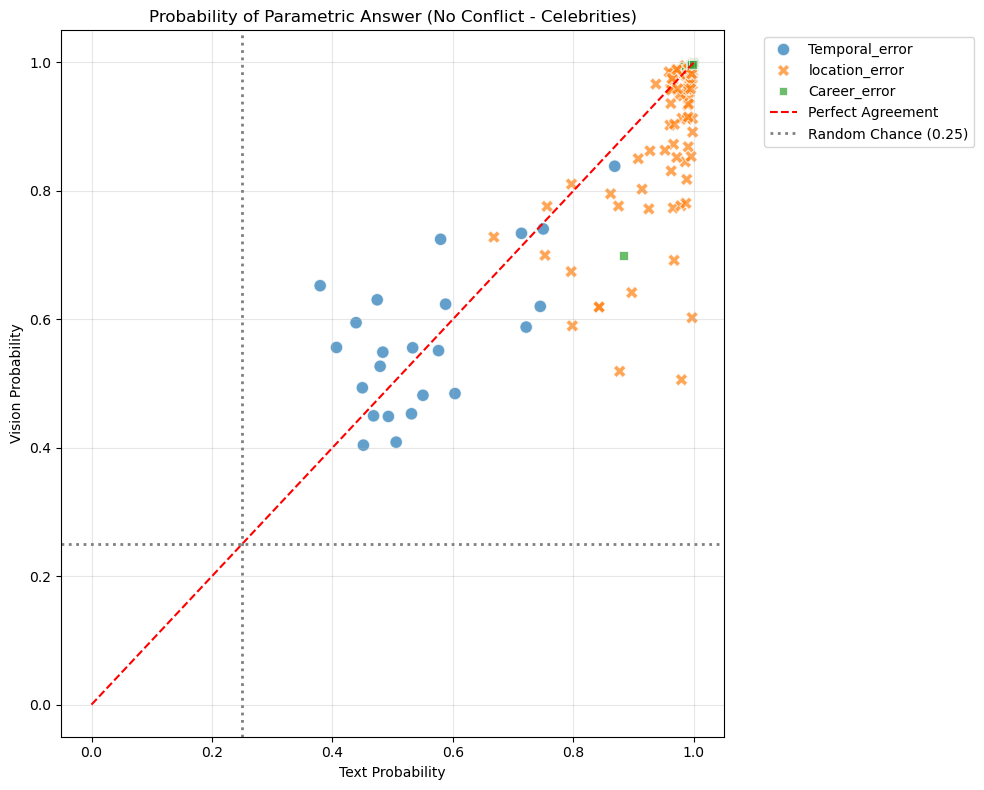

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to extract the probability of the ground truth answer
def get_parametric_prob(row):
    return row[f"Prob_{row['Ground_Truth']}"]

# 1. Prepare the data
plot_df = pd.DataFrame({
    'Category': df_lang['Category'],
    'Text_Prob': df_lang.apply(get_parametric_prob, axis=1),
    'Vision_Prob': df_vis.apply(get_parametric_prob, axis=1)
})

# 2. Create the Scatter Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=plot_df,
    x='Text_Prob',
    y='Vision_Prob',
    hue='Category',
    style='Category',
    s=80,
    alpha=0.7
)

# 3. Add lines
# Diagonal reference (Perfect Agreement)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfect Agreement')

# Random Chance Baselines (0.25)
plt.axvline(x=0.25, color='gray', linestyle=':', linewidth=2, label='Random Chance (0.25)')
plt.axhline(y=0.25, color='gray', linestyle=':', linewidth=2)

plt.title('Probability of Parametric Answer (No Conflict - Celebrities)')
plt.xlabel('Text Probability')
plt.ylabel('Vision Probability')

# 4. Final Formatting
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='-', alpha=0.3)
plt.tight_layout()

plt.show()

# ***Logo visualizations***

## Find where ground truth cant be answered

In [29]:
df_inherent_text = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/No_RAG_Experiment_Results_logo.csv")
df_inherent_vision = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/No_RAG_VISION_Experiment_Results_logo.csv")
df_inherent_text

def get_correct_indices(df):
    # 1. Define the probability columns
    prob_cols = ['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']
    
    # 2. Find the column name with the max value for each row (e.g., "Prob_A")
    # idxmax(axis=1) returns the column label of the maximum value
    predicted_col = df[prob_cols].idxmax(axis=1)
    
    # 3. Clean the prediction to match Ground_Truth format (e.g., "Prob_A" -> "A")
    predicted_choice = predicted_col.str.replace('Prob_', '')
    
    # 4. Compare with Ground Truth
    # We strip whitespace from both just to be safe (e.g. " A" vs "A")
    is_correct = predicted_choice.str.strip() == df['Ground_Truth'].str.strip()
    
    return is_correct

# Get the boolean mask (True/False) for both dataframes
text_correct_mask = get_correct_indices(df_inherent_text)
vision_correct_mask = get_correct_indices(df_inherent_vision)

# Find where BOTH are True
# We use the bitwise AND operator '&'
both_correct_mask = text_correct_mask & vision_correct_mask

# Extract the actual indices
correct_indices = df_inherent_text.index[both_correct_mask].tolist()

print(f"Number of matches: {len(correct_indices)}")
print("Indices:", correct_indices)

Number of matches: 159
Indices: [1, 2, 3, 4, 5, 7, 8, 10, 11, 13, 14, 15, 16, 17, 19, 20, 22, 23, 25, 26, 28, 29, 31, 32, 34, 35, 36, 37, 38, 40, 41, 44, 46, 47, 49, 50, 52, 53, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 73, 74, 77, 80, 81, 82, 83, 85, 86, 87, 89, 91, 92, 93, 95, 97, 98, 99, 100, 101, 103, 104, 107, 109, 110, 112, 113, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 127, 128, 130, 131, 133, 134, 136, 137, 139, 140, 142, 143, 145, 146, 148, 149, 151, 152, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 167, 169, 171, 172, 173, 175, 176, 178, 179, 180, 181, 182, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 197, 199, 200, 202, 203, 205, 206, 207, 208, 209, 210, 211, 212, 214, 215, 217, 218, 220, 221]


In [30]:
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/RAG_Experiment_Results_logo.csv")
df = df.iloc[correct_indices]
df

,ID,Instance,Category,Mis_Knowledge_Key,Context,Query,Response,Prob_A,Prob_B,Prob_C,Prob_D,Ground_Truth,Mis_Answer_Label
1,1,Nike,creator_error,mis_knowledge1,Nike was created in 1964. The creator of Nike ...,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nCo...,0.004051,0.976074,0.016922,0.002785,B,C
2,1,Nike,content_error,mis_knowledge1,Nike was created in 1964. The creator of Nike ...,What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nCo...,0.000501,0.034546,0.963379,0.001415,C,B
3,2,Coca-Cola,time_error,mis_knowledge1,Coca-Cola was created in 1890. The creator of ...,When was the brand associated with the logo es...,system\nYou are a helpful assistant.\nuser\nCo...,0.002905,0.979004,0.009827,0.008400,D,B
4,2,Coca-Cola,creator_error,mis_knowledge1,Coca-Cola was created in 1886. The creator of ...,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nCo...,0.000434,0.993164,0.000285,0.006287,B,D
5,2,Coca-Cola,content_error,mis_knowledge1,Coca-Cola was created in 1886. The creator of ...,What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nCo...,0.001133,0.143799,0.854004,0.000954,C,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,72,Wikipedia,content_error,mis_knowledge1,"Wikipedia is a free online encyclopedia, creat...",What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nCo...,0.000969,0.967773,0.000108,0.031113,B,D
217,73,GitHub,creator_error,mis_knowledge1,GitHub was created in 2008. The creators of Gi...,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nCo...,0.007240,0.359863,0.001182,0.631836,B,D
218,73,GitHub,content_error,mis_knowledge1,GitHub was created in 2008. The creators of Gi...,What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nCo...,0.047211,0.003586,0.000633,0.948730,D,A
220,74,Meta,creator_error,mis_knowledge1,Meta was created in 2004. The creator of Meta ...,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nCo...,0.001356,0.998535,0.000033,0.000131,A,B


In [31]:
df['Category'].value_counts()

Category
content_error    73
creator_error    65
time_error       21
Name: count, dtype: int64

Overall Accuracy: 56.60%
Category
content_error    72.602740
creator_error    56.923077
time_error        0.000000
Name: Is_Correct, dtype: float64


/tmp/ipykernel_2250032/3291027162.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')


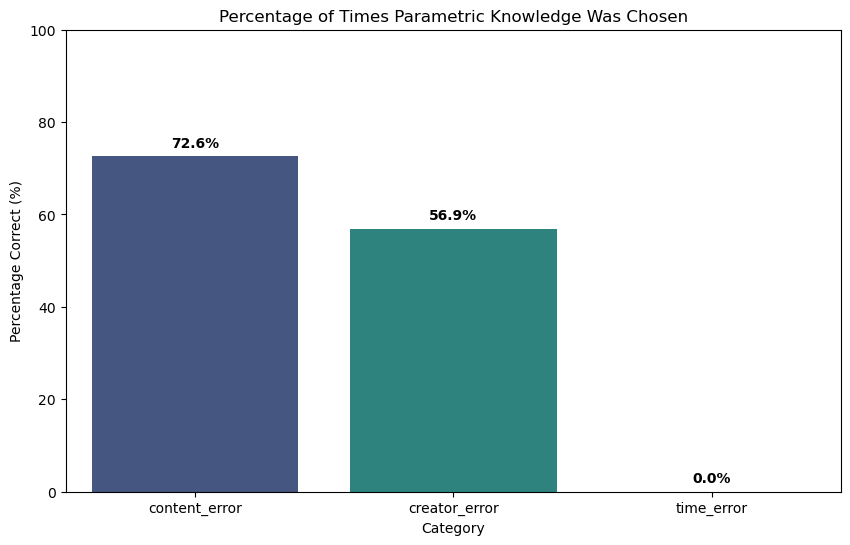

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

probs = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].values
df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']] = probs / probs.sum(axis=1, keepdims=True)

# ---------------------------------------------------------
# ANALYSIS CODE START
# ---------------------------------------------------------

# 1. Determine the model's chosen answer (highest probability)
# idxmax returns the column name (e.g., "Prob_A"). We strip "Prob_" to get "A".
df['Predicted_Choice'] = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].idxmax(axis=1).apply(lambda x: x.split('_')[1])

# 2. Check if it matches Ground Truth
df['Is_Correct'] = df['Predicted_Choice'] == df['Ground_Truth']

# 3. Calculate Percentage
overall_accuracy = df['Is_Correct'].mean() * 100
accuracy_by_category = df.groupby('Category')['Is_Correct'].mean() * 100

print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(accuracy_by_category)

# 4. Visualization
plt.figure(figsize=(10, 6))

# We can plot accuracy by category
sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')

plt.ylabel('Percentage Correct (%)')
plt.xlabel('Category')
plt.title('Percentage of Times Parametric Knowledge Was Chosen')
plt.ylim(0, 100)

# Add text labels on bars
for i, v in enumerate(accuracy_by_category.values):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()

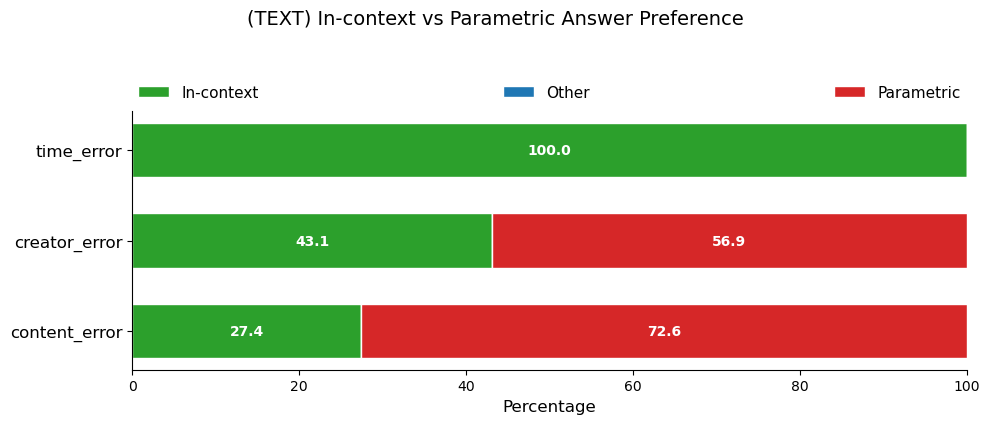

In [33]:
def classify_outcome(row):
    # Clean whitespace just in case (e.g., " A" vs "A")
    pred = str(row['Predicted_Choice'])
    gt = str(row['Ground_Truth'])
    mis = str(row['Mis_Answer_Label'])
    
    if pred == gt:
        return "Parametric"
    elif pred == mis:
        return "In-context"
    else:
        return "Other"

df['Outcome'] = df.apply(classify_outcome, axis=1)

group_col = 'Category' # Change to 'Model' if you have a model column
outcome_counts = df.groupby([group_col, 'Outcome']).size().unstack(fill_value=0)

# Calculate percentages
outcome_pct = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100

# Ensure all columns exist (in case one category has 0 "Other")
for col in ['In-context', 'Parametric', 'Other']:
    if col not in outcome_pct.columns:
        outcome_pct[col] = 0

# Reorder columns to match the visual preference
# (e.g., In-context (Left), Parametric (Middle/Right), Other (Right))
outcome_pct = outcome_pct[['In-context', 'Other', 'Parametric']]


# ---------------------------------------------------------
# 4. Plotting
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 4))

# Define Colors matching the vibe of the reference
# Reference: Knowledge(Red), Other(Blue), Vision(Green)
# Your mapping: In-context (GT), Parametric (Mis), Other
colors = {
    'In-context': '#2ca02c',  # Green (Success/Ground Truth)
    'Other': '#1f77b4',       # Blue
    'Parametric': '#d62728'   # Red (Conflict/Mis-knowledge)
}
# Or if you want to strictly match the reference image's color-to-concept mapping:
# colors = {'In-context': '#d62728', 'Other': '#1f77b4', 'Parametric': '#2ca02c'}

# Stacked Bar Plot
y_pos = np.arange(len(outcome_pct))
height = 0.6

left_offset = np.zeros(len(outcome_pct))

categories = outcome_pct.columns # ['In-context', 'Other', 'Parametric']

for cat in categories:
    values = outcome_pct[cat].values
    ax.barh(y_pos, values, height, left=left_offset, color=colors[cat], label=cat, edgecolor='white')
    
    # Add percentage text inside bars
    for i, (val, left) in enumerate(zip(values, left_offset)):
        if val > 5: # Only show text if the bar is wide enough
            # Text color logic: white for dark bars
            ax.text(left + val/2, i, f'{val:.1f}', 
                    ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    
    left_offset += values

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(outcome_pct.index, fontsize=12)
ax.set_xlim(0, 100)
ax.set_xlabel('Percentage', fontsize=12)

# Move Legend to top (like the reference)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0., frameon=False, fontsize=11)

# Remove top and right spines for cleanliness
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.suptitle(
    "(TEXT) In-context vs Parametric Answer Preference",
    fontsize=14,
    y=1.05  # adjust vertical position
)

plt.tight_layout()
plt.show()

In [34]:
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/No_RAG_Experiment_Results_logo.csv")
df

,ID,Instance,Category,Mis_Knowledge_Key,Context,Query,Response,Prob_A,Prob_B,Prob_C,Prob_D,Ground_Truth,Mis_Answer_Label
0,1,Nike,time_error,mis_knowledge1,NaN,When was the brand associated with the logo es...,system\nYou are a helpful assistant.\nuser\nGi...,0.472412,0.351074,0.100586,0.075928,C,A
1,1,Nike,creator_error,mis_knowledge1,NaN,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nGi...,0.003349,0.996094,0.000192,0.000388,B,C
2,1,Nike,content_error,mis_knowledge1,NaN,What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nGi...,0.000440,0.000134,0.999023,0.000626,C,B
3,2,Coca-Cola,time_error,mis_knowledge1,NaN,When was the brand associated with the logo es...,system\nYou are a helpful assistant.\nuser\nGi...,0.097961,0.036896,0.057587,0.807617,D,B
4,2,Coca-Cola,creator_error,mis_knowledge1,NaN,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nGi...,0.000721,0.998535,0.000225,0.000427,B,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,73,GitHub,creator_error,mis_knowledge1,NaN,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nGi...,0.011856,0.987305,0.000306,0.000505,B,D
218,73,GitHub,content_error,mis_knowledge1,NaN,What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nGi...,0.001185,0.001955,0.000226,0.996582,D,A
219,74,Meta,time_error,mis_knowledge1,NaN,When was the brand associated with the logo es...,system\nYou are a helpful assistant.\nuser\nGi...,0.373779,0.367920,0.093750,0.164551,D,B
220,74,Meta,creator_error,mis_knowledge1,NaN,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nGi...,0.998047,0.001293,0.000090,0.000583,A,B


Overall Accuracy: 75.68%
Category
content_error    98.648649
creator_error    89.189189
time_error       39.189189
Name: Is_Correct, dtype: float64


/tmp/ipykernel_2250032/2659512089.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')


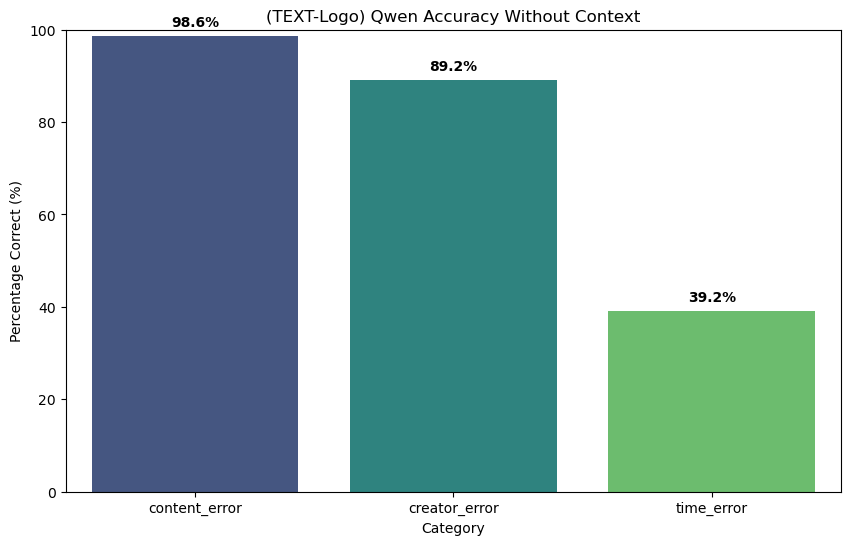

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

probs = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].values
df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']] = probs / probs.sum(axis=1, keepdims=True)

# ---------------------------------------------------------
# ANALYSIS CODE START
# ---------------------------------------------------------

# 1. Determine the model's chosen answer (highest probability)
# idxmax returns the column name (e.g., "Prob_A"). We strip "Prob_" to get "A".
df['Predicted_Choice'] = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].idxmax(axis=1).apply(lambda x: x.split('_')[1])

# 2. Check if it matches Ground Truth
df['Is_Correct'] = df['Predicted_Choice'] == df['Ground_Truth']

# 3. Calculate Percentage
overall_accuracy = df['Is_Correct'].mean() * 100
accuracy_by_category = df.groupby('Category')['Is_Correct'].mean() * 100

print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(accuracy_by_category)

# 4. Visualization
plt.figure(figsize=(10, 6))

# We can plot accuracy by category
sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')

plt.ylabel('Percentage Correct (%)')
plt.xlabel('Category')
plt.title('(TEXT-Logo) Qwen Accuracy Without Context')
plt.ylim(0, 100)

# Add text labels on bars
for i, v in enumerate(accuracy_by_category.values):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()


In [36]:
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/RAG_VISION_Experiment_Results_logo.csv")
df = df.iloc[correct_indices]
df

,ID,Instance,Category,Mis_Knowledge_Key,Context,Query,Response,Prob_A,Prob_B,Prob_C,Prob_D,Ground_Truth,Mis_Answer_Label
1,1,Nike,creator_error,mis_knowledge1,Nike was created in 1964. The creator of Nike ...,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nCo...,0.009163,0.986816,0.002750,0.001078,B,C
2,1,Nike,content_error,mis_knowledge1,Nike was created in 1964. The creator of Nike ...,What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nCo...,0.000404,0.001500,0.997559,0.000433,C,B
3,2,Coca-Cola,time_error,mis_knowledge1,Coca-Cola was created in 1890. The creator of ...,When was the brand associated with the logo es...,system\nYou are a helpful assistant.\nuser\nCo...,0.001236,0.991699,0.003929,0.003283,D,B
4,2,Coca-Cola,creator_error,mis_knowledge1,Coca-Cola was created in 1886. The creator of ...,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nCo...,0.000919,0.992676,0.000341,0.006184,B,D
5,2,Coca-Cola,content_error,mis_knowledge1,Coca-Cola was created in 1886. The creator of ...,What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nCo...,0.000700,0.058289,0.940430,0.000399,C,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,72,Wikipedia,content_error,mis_knowledge1,"Wikipedia is a free online encyclopedia, creat...",What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nCo...,0.000812,0.962891,0.000099,0.036194,B,D
217,73,GitHub,creator_error,mis_knowledge1,GitHub was created in 2008. The creators of Gi...,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nCo...,0.005749,0.859863,0.000506,0.133911,B,D
218,73,GitHub,content_error,mis_knowledge1,GitHub was created in 2008. The creators of Gi...,What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nCo...,0.164062,0.002396,0.000335,0.833008,D,A
220,74,Meta,creator_error,mis_knowledge1,Meta was created in 2004. The creator of Meta ...,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nCo...,0.005219,0.994629,0.000046,0.000101,A,B


Overall Accuracy: 65.41%
Category
content_error    87.671233
creator_error    61.538462
time_error        0.000000
Name: Is_Correct, dtype: float64


/tmp/ipykernel_2250032/3291027162.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')


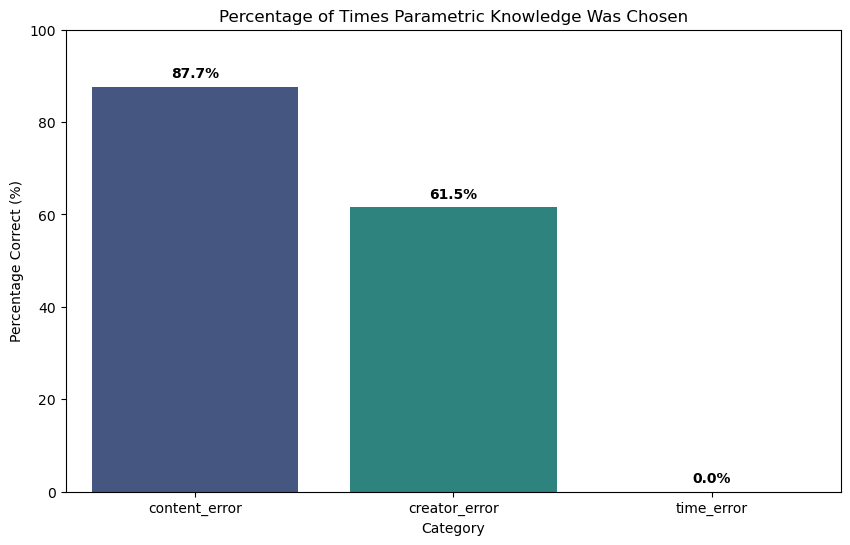

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

probs = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].values
df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']] = probs / probs.sum(axis=1, keepdims=True)

# ---------------------------------------------------------
# ANALYSIS CODE START
# ---------------------------------------------------------

# 1. Determine the model's chosen answer (highest probability)
# idxmax returns the column name (e.g., "Prob_A"). We strip "Prob_" to get "A".
df['Predicted_Choice'] = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].idxmax(axis=1).apply(lambda x: x.split('_')[1])

# 2. Check if it matches Ground Truth
df['Is_Correct'] = df['Predicted_Choice'] == df['Ground_Truth']

# 3. Calculate Percentage
overall_accuracy = df['Is_Correct'].mean() * 100
accuracy_by_category = df.groupby('Category')['Is_Correct'].mean() * 100

print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(accuracy_by_category)

# 4. Visualization
plt.figure(figsize=(10, 6))

# We can plot accuracy by category
sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')

plt.ylabel('Percentage Correct (%)')
plt.xlabel('Category')
plt.title('Percentage of Times Parametric Knowledge Was Chosen')
plt.ylim(0, 100)

# Add text labels on bars
for i, v in enumerate(accuracy_by_category.values):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()

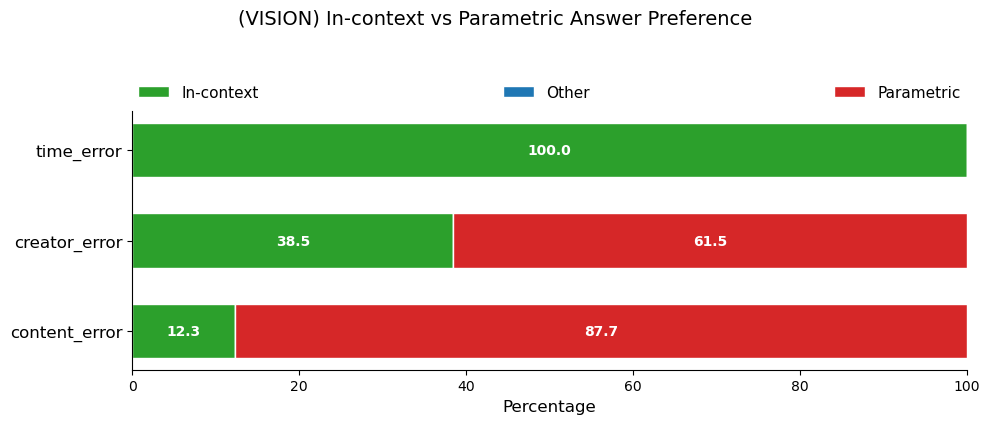

In [38]:
def classify_outcome(row):
    # Clean whitespace just in case (e.g., " A" vs "A")
    pred = str(row['Predicted_Choice'])
    gt = str(row['Ground_Truth'])
    mis = str(row['Mis_Answer_Label'])
    
    if pred == gt:
        return "Parametric"
    elif pred == mis:
        return "In-context"
    else:
        return "Other"

df['Outcome'] = df.apply(classify_outcome, axis=1)

group_col = 'Category' # Change to 'Model' if you have a model column
outcome_counts = df.groupby([group_col, 'Outcome']).size().unstack(fill_value=0)

# Calculate percentages
outcome_pct = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100

# Ensure all columns exist (in case one category has 0 "Other")
for col in ['In-context', 'Parametric', 'Other']:
    if col not in outcome_pct.columns:
        outcome_pct[col] = 0

# Reorder columns to match the visual preference
# (e.g., In-context (Left), Parametric (Middle/Right), Other (Right))
outcome_pct = outcome_pct[['In-context', 'Other', 'Parametric']]


# ---------------------------------------------------------
# 4. Plotting
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 4))

# Define Colors matching the vibe of the reference
# Reference: Knowledge(Red), Other(Blue), Vision(Green)
# Your mapping: In-context (GT), Parametric (Mis), Other
colors = {
    'In-context': '#2ca02c',  # Green (Success/Ground Truth)
    'Other': '#1f77b4',       # Blue
    'Parametric': '#d62728'   # Red (Conflict/Mis-knowledge)
}
# Or if you want to strictly match the reference image's color-to-concept mapping:
# colors = {'In-context': '#d62728', 'Other': '#1f77b4', 'Parametric': '#2ca02c'}

# Stacked Bar Plot
y_pos = np.arange(len(outcome_pct))
height = 0.6

left_offset = np.zeros(len(outcome_pct))

categories = outcome_pct.columns # ['In-context', 'Other', 'Parametric']

for cat in categories:
    values = outcome_pct[cat].values
    ax.barh(y_pos, values, height, left=left_offset, color=colors[cat], label=cat, edgecolor='white')
    
    # Add percentage text inside bars
    for i, (val, left) in enumerate(zip(values, left_offset)):
        if val > 5: # Only show text if the bar is wide enough
            # Text color logic: white for dark bars
            ax.text(left + val/2, i, f'{val:.1f}', 
                    ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    
    left_offset += values

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(outcome_pct.index, fontsize=12)
ax.set_xlim(0, 100)
ax.set_xlabel('Percentage', fontsize=12)

# Move Legend to top (like the reference)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0., frameon=False, fontsize=11)

# Remove top and right spines for cleanliness
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.suptitle(
    "(VISION) In-context vs Parametric Answer Preference",
    fontsize=14,
    y=1.05  # adjust vertical position
)

plt.tight_layout()
plt.show()

In [39]:
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/No_RAG_VISION_Experiment_Results_logo.csv")

Overall Accuracy: 74.32%
Category
content_error    100.000000
creator_error     87.837838
time_error        35.135135
Name: Is_Correct, dtype: float64


/tmp/ipykernel_2250032/3467363854.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')


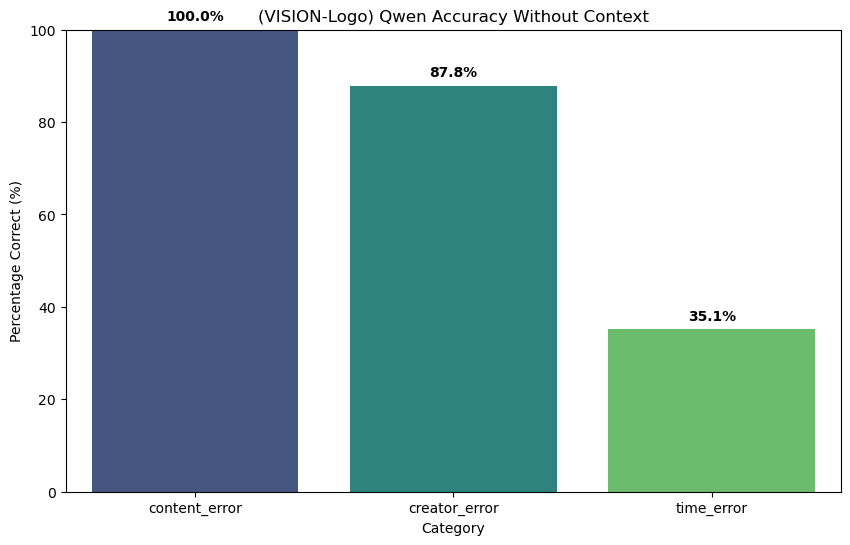

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

probs = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].values
df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']] = probs / probs.sum(axis=1, keepdims=True)

# ---------------------------------------------------------
# ANALYSIS CODE START
# ---------------------------------------------------------

# 1. Determine the model's chosen answer (highest probability)
# idxmax returns the column name (e.g., "Prob_A"). We strip "Prob_" to get "A".
df['Predicted_Choice'] = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].idxmax(axis=1).apply(lambda x: x.split('_')[1])

# 2. Check if it matches Ground Truth
df['Is_Correct'] = df['Predicted_Choice'] == df['Ground_Truth']

# 3. Calculate Percentage
overall_accuracy = df['Is_Correct'].mean() * 100
accuracy_by_category = df.groupby('Category')['Is_Correct'].mean() * 100

print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(accuracy_by_category)

# 4. Visualization
plt.figure(figsize=(10, 6))

# We can plot accuracy by category
sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')

plt.ylabel('Percentage Correct (%)')
plt.xlabel('Category')
plt.title('(VISION-Logo) Qwen Accuracy Without Context')
plt.ylim(0, 100)

# Add text labels on bars
for i, v in enumerate(accuracy_by_category.values):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()

## Logo With Vision-RAG

In [41]:
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Image_RAG_Experiment_Results_logo.csv")
df = df.iloc[correct_indices]
df

,ID,Instance,Category,Mis_Knowledge_Key,Context,Query,Response,Prob_A,Prob_B,Prob_C,Prob_D,Ground_Truth,Mis_Answer_Label
1,1,Nike,creator_error,mis_knowledge1,The brand pictured was created in 1964. The cr...,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nCo...,0.002142,0.994629,0.001997,0.001036,B,C
2,1,Nike,content_error,mis_knowledge1,The brand pictured was created in 1964. The cr...,What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nCo...,0.000530,0.001925,0.997070,0.000702,C,B
3,2,Coca-Cola,time_error,mis_knowledge1,The brand pictured was created in 1890. The cr...,When was the brand associated with the logo es...,system\nYou are a helpful assistant.\nuser\nCo...,0.001498,0.988770,0.004875,0.004688,D,B
4,2,Coca-Cola,creator_error,mis_knowledge1,The brand pictured was created in 1886. The cr...,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nCo...,0.000465,0.998535,0.000163,0.000962,B,D
5,2,Coca-Cola,content_error,mis_knowledge1,The brand pictured was created in 1886. The cr...,What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nCo...,0.000578,0.008438,0.990723,0.000465,C,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,72,Wikipedia,content_error,mis_knowledge1,The brand pictured is a free online encycloped...,What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nCo...,0.000533,0.721191,0.000095,0.278076,B,D
217,73,GitHub,creator_error,mis_knowledge1,The brand pictured was created in 2008. The cr...,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nCo...,0.004780,0.961914,0.000844,0.032410,B,D
218,73,GitHub,content_error,mis_knowledge1,The brand pictured was created in 2008. The cr...,What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nCo...,0.037750,0.003456,0.000348,0.958496,D,A
220,74,Meta,creator_error,mis_knowledge1,The brand pictured was created in 2004. The cr...,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nCo...,0.003403,0.996582,0.000056,0.000189,A,B


Overall Accuracy: 74.84%
Category
content_error    95.890411
creator_error    73.846154
time_error        4.761905
Name: Is_Correct, dtype: float64


/tmp/ipykernel_2250032/3291027162.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')


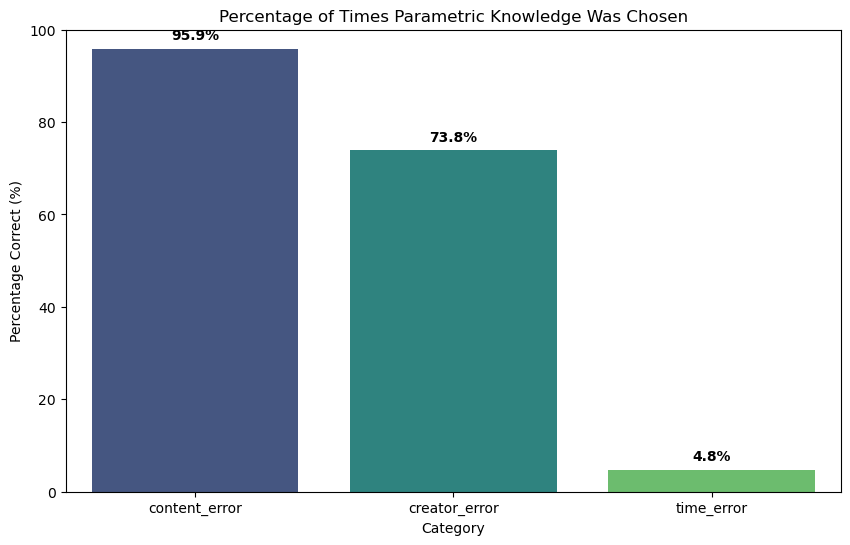

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

probs = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].values
df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']] = probs / probs.sum(axis=1, keepdims=True)

# ---------------------------------------------------------
# ANALYSIS CODE START
# ---------------------------------------------------------

# 1. Determine the model's chosen answer (highest probability)
# idxmax returns the column name (e.g., "Prob_A"). We strip "Prob_" to get "A".
df['Predicted_Choice'] = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].idxmax(axis=1).apply(lambda x: x.split('_')[1])

# 2. Check if it matches Ground Truth
df['Is_Correct'] = df['Predicted_Choice'] == df['Ground_Truth']

# 3. Calculate Percentage
overall_accuracy = df['Is_Correct'].mean() * 100
accuracy_by_category = df.groupby('Category')['Is_Correct'].mean() * 100

print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(accuracy_by_category)

# 4. Visualization
plt.figure(figsize=(10, 6))

# We can plot accuracy by category
sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')

plt.ylabel('Percentage Correct (%)')
plt.xlabel('Category')
plt.title('Percentage of Times Parametric Knowledge Was Chosen')
plt.ylim(0, 100)

# Add text labels on bars
for i, v in enumerate(accuracy_by_category.values):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()

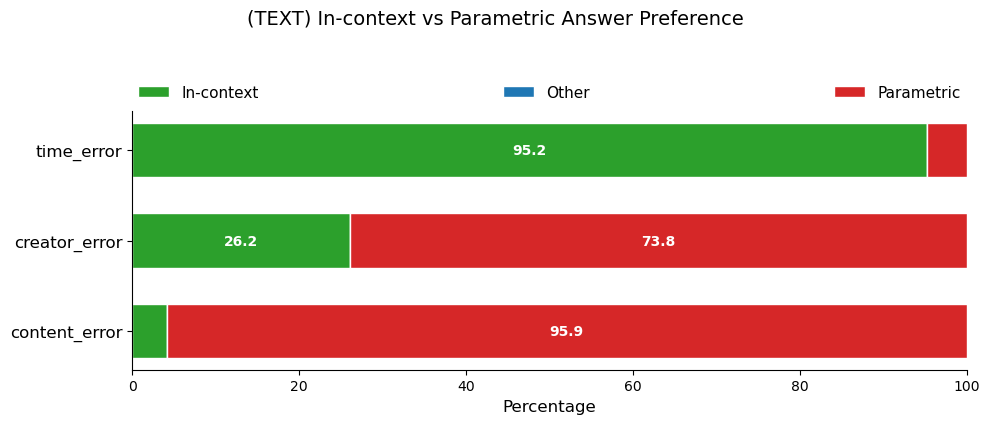

In [44]:
def classify_outcome(row):
    # Clean whitespace just in case (e.g., " A" vs "A")
    pred = str(row['Predicted_Choice'])
    gt = str(row['Ground_Truth'])
    mis = str(row['Mis_Answer_Label'])
    
    if pred == gt:
        return "Parametric"
    elif pred == mis:
        return "In-context"
    else:
        return "Other"

df['Outcome'] = df.apply(classify_outcome, axis=1)

group_col = 'Category' # Change to 'Model' if you have a model column
outcome_counts = df.groupby([group_col, 'Outcome']).size().unstack(fill_value=0)

# Calculate percentages
outcome_pct = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100

# Ensure all columns exist (in case one category has 0 "Other")
for col in ['In-context', 'Parametric', 'Other']:
    if col not in outcome_pct.columns:
        outcome_pct[col] = 0

# Reorder columns to match the visual preference
# (e.g., In-context (Left), Parametric (Middle/Right), Other (Right))
outcome_pct = outcome_pct[['In-context', 'Other', 'Parametric']]


# ---------------------------------------------------------
# 4. Plotting
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 4))

# Define Colors matching the vibe of the reference
# Reference: Knowledge(Red), Other(Blue), Vision(Green)
# Your mapping: In-context (GT), Parametric (Mis), Other
colors = {
    'In-context': '#2ca02c',  # Green (Success/Ground Truth)
    'Other': '#1f77b4',       # Blue
    'Parametric': '#d62728'   # Red (Conflict/Mis-knowledge)
}
# Or if you want to strictly match the reference image's color-to-concept mapping:
# colors = {'In-context': '#d62728', 'Other': '#1f77b4', 'Parametric': '#2ca02c'}

# Stacked Bar Plot
y_pos = np.arange(len(outcome_pct))
height = 0.6

left_offset = np.zeros(len(outcome_pct))

categories = outcome_pct.columns # ['In-context', 'Other', 'Parametric']

for cat in categories:
    values = outcome_pct[cat].values
    ax.barh(y_pos, values, height, left=left_offset, color=colors[cat], label=cat, edgecolor='white')
    
    # Add percentage text inside bars
    for i, (val, left) in enumerate(zip(values, left_offset)):
        if val > 5: # Only show text if the bar is wide enough
            # Text color logic: white for dark bars
            ax.text(left + val/2, i, f'{val:.1f}', 
                    ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    
    left_offset += values

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(outcome_pct.index, fontsize=12)
ax.set_xlim(0, 100)
ax.set_xlabel('Percentage', fontsize=12)

# Move Legend to top (like the reference)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0., frameon=False, fontsize=11)

# Remove top and right spines for cleanliness
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.suptitle(
    "(TEXT) In-context vs Parametric Answer Preference",
    fontsize=14,
    y=1.05  # adjust vertical position
)

plt.tight_layout()
plt.show()

In [46]:
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/Image_RAG_VISION_Experiment_Results_logo.csv")
df = df.iloc[correct_indices]
df

,ID,Instance,Category,Mis_Knowledge_Key,Context,Query,Response,Prob_A,Prob_B,Prob_C,Prob_D,Ground_Truth,Mis_Answer_Label
1,1,Nike,creator_error,mis_knowledge1,The brand pictured was created in 1964. The cr...,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nCo...,0.007336,0.991211,0.000883,0.000743,B,C
2,1,Nike,content_error,mis_knowledge1,The brand pictured was created in 1964. The cr...,What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nCo...,0.000828,0.001115,0.997559,0.000319,C,B
3,2,Coca-Cola,time_error,mis_knowledge1,The brand pictured was created in 1890. The cr...,When was the brand associated with the logo es...,system\nYou are a helpful assistant.\nuser\nCo...,0.001481,0.992676,0.002598,0.003389,D,B
4,2,Coca-Cola,creator_error,mis_knowledge1,The brand pictured was created in 1886. The cr...,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nCo...,0.002062,0.995605,0.000286,0.002029,B,D
5,2,Coca-Cola,content_error,mis_knowledge1,The brand pictured was created in 1886. The cr...,What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nCo...,0.001212,0.010803,0.987793,0.000222,C,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,72,Wikipedia,content_error,mis_knowledge1,The brand pictured is a free online encycloped...,What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nCo...,0.001496,0.710938,0.000091,0.287354,B,D
217,73,GitHub,creator_error,mis_knowledge1,The brand pictured was created in 2008. The cr...,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nCo...,0.009216,0.985352,0.000434,0.005051,B,D
218,73,GitHub,content_error,mis_knowledge1,The brand pictured was created in 2008. The cr...,What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nCo...,0.103333,0.003323,0.000468,0.893066,D,A
220,74,Meta,creator_error,mis_knowledge1,The brand pictured was created in 2004. The cr...,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nCo...,0.021286,0.978516,0.000082,0.000152,A,B


Overall Accuracy: 74.21%
Category
content_error    95.890411
creator_error    72.307692
time_error        4.761905
Name: Is_Correct, dtype: float64


/tmp/ipykernel_2250032/3291027162.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')


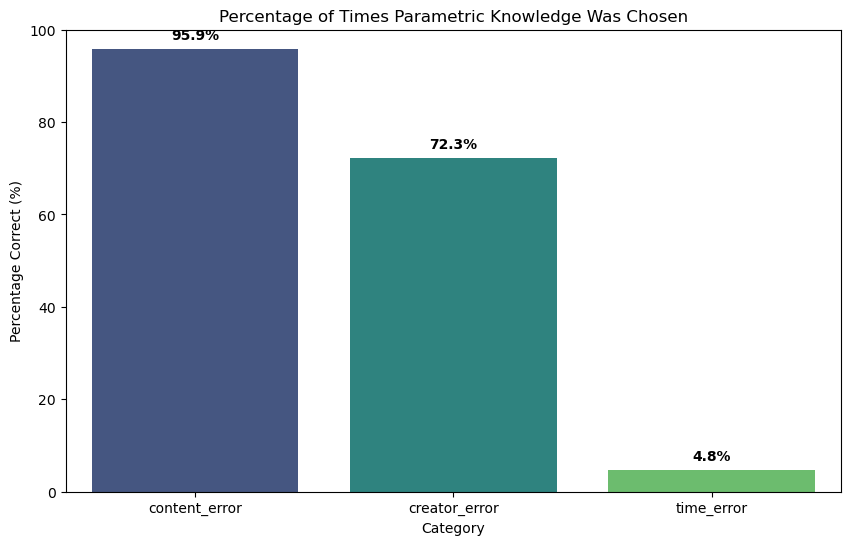

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

probs = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].values
df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']] = probs / probs.sum(axis=1, keepdims=True)

# ---------------------------------------------------------
# ANALYSIS CODE START
# ---------------------------------------------------------

# 1. Determine the model's chosen answer (highest probability)
# idxmax returns the column name (e.g., "Prob_A"). We strip "Prob_" to get "A".
df['Predicted_Choice'] = df[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].idxmax(axis=1).apply(lambda x: x.split('_')[1])

# 2. Check if it matches Ground Truth
df['Is_Correct'] = df['Predicted_Choice'] == df['Ground_Truth']

# 3. Calculate Percentage
overall_accuracy = df['Is_Correct'].mean() * 100
accuracy_by_category = df.groupby('Category')['Is_Correct'].mean() * 100

print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(accuracy_by_category)

# 4. Visualization
plt.figure(figsize=(10, 6))

# We can plot accuracy by category
sns.barplot(x=accuracy_by_category.index, y=accuracy_by_category.values, palette='viridis')

plt.ylabel('Percentage Correct (%)')
plt.xlabel('Category')
plt.title('Percentage of Times Parametric Knowledge Was Chosen')
plt.ylim(0, 100)

# Add text labels on bars
for i, v in enumerate(accuracy_by_category.values):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontweight='bold')
plt.show()

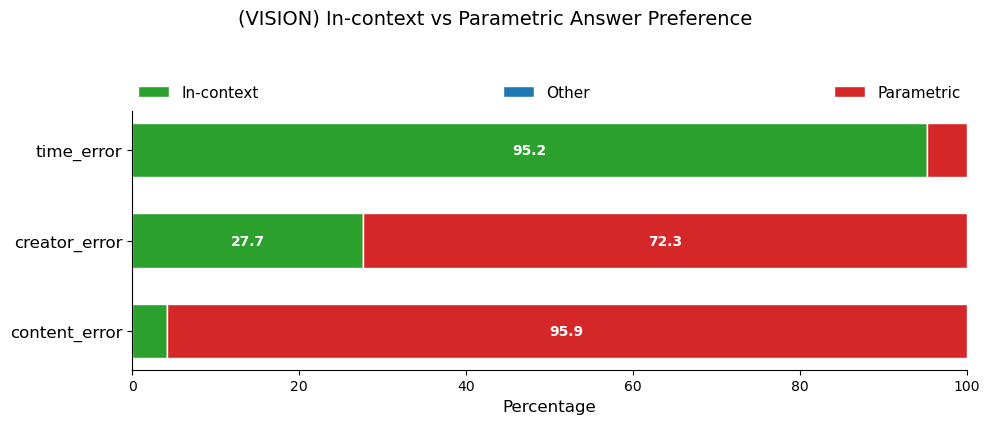

In [48]:
def classify_outcome(row):
    # Clean whitespace just in case (e.g., " A" vs "A")
    pred = str(row['Predicted_Choice'])
    gt = str(row['Ground_Truth'])
    mis = str(row['Mis_Answer_Label'])
    
    if pred == gt:
        return "Parametric"
    elif pred == mis:
        return "In-context"
    else:
        return "Other"

df['Outcome'] = df.apply(classify_outcome, axis=1)

group_col = 'Category' # Change to 'Model' if you have a model column
outcome_counts = df.groupby([group_col, 'Outcome']).size().unstack(fill_value=0)

# Calculate percentages
outcome_pct = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100

# Ensure all columns exist (in case one category has 0 "Other")
for col in ['In-context', 'Parametric', 'Other']:
    if col not in outcome_pct.columns:
        outcome_pct[col] = 0

# Reorder columns to match the visual preference
# (e.g., In-context (Left), Parametric (Middle/Right), Other (Right))
outcome_pct = outcome_pct[['In-context', 'Other', 'Parametric']]


# ---------------------------------------------------------
# 4. Plotting
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 4))

# Define Colors matching the vibe of the reference
# Reference: Knowledge(Red), Other(Blue), Vision(Green)
# Your mapping: In-context (GT), Parametric (Mis), Other
colors = {
    'In-context': '#2ca02c',  # Green (Success/Ground Truth)
    'Other': '#1f77b4',       # Blue
    'Parametric': '#d62728'   # Red (Conflict/Mis-knowledge)
}
# Or if you want to strictly match the reference image's color-to-concept mapping:
# colors = {'In-context': '#d62728', 'Other': '#1f77b4', 'Parametric': '#2ca02c'}

# Stacked Bar Plot
y_pos = np.arange(len(outcome_pct))
height = 0.6

left_offset = np.zeros(len(outcome_pct))

categories = outcome_pct.columns # ['In-context', 'Other', 'Parametric']

for cat in categories:
    values = outcome_pct[cat].values
    ax.barh(y_pos, values, height, left=left_offset, color=colors[cat], label=cat, edgecolor='white')
    
    # Add percentage text inside bars
    for i, (val, left) in enumerate(zip(values, left_offset)):
        if val > 5: # Only show text if the bar is wide enough
            # Text color logic: white for dark bars
            ax.text(left + val/2, i, f'{val:.1f}', 
                    ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    
    left_offset += values

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(outcome_pct.index, fontsize=12)
ax.set_xlim(0, 100)
ax.set_xlabel('Percentage', fontsize=12)

# Move Legend to top (like the reference)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0., frameon=False, fontsize=11)

# Remove top and right spines for cleanliness
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.suptitle(
    "(VISION) In-context vs Parametric Answer Preference",
    fontsize=14,
    y=1.05  # adjust vertical position
)

plt.tight_layout()
plt.show()

In [50]:
outcome_pct

Outcome,In-context,Other,Parametric
Category,,,
content_error,4.109589,0,95.890411
creator_error,27.692308,0,72.307692
time_error,95.238095,0,4.761905


# Compare vision to language

In [35]:
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/No_RAG_Experiment_Results_logo.csv")
df_lang = df.iloc[correct_indices]
df_lang
df = pd.read_csv("/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Results/No_RAG_VISION_Experiment_Results_logo.csv")
df_vis = df.iloc[correct_indices]
df_vis

,ID,Instance,Category,Mis_Knowledge_Key,Context,Query,Response,Prob_A,Prob_B,Prob_C,Prob_D,Ground_Truth,Mis_Answer_Label
1,1,Nike,creator_error,mis_knowledge1,NaN,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nGi...,0.009705,0.989746,0.000142,0.000191,B,C
2,1,Nike,content_error,mis_knowledge1,NaN,What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nGi...,0.000584,0.000138,0.999023,0.000236,C,B
3,2,Coca-Cola,time_error,mis_knowledge1,NaN,When was the brand associated with the logo es...,system\nYou are a helpful assistant.\nuser\nGi...,0.025482,0.020798,0.027115,0.926758,D,B
4,2,Coca-Cola,creator_error,mis_knowledge1,NaN,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nGi...,0.001116,0.998535,0.000249,0.000234,B,D
5,2,Coca-Cola,content_error,mis_knowledge1,NaN,What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nGi...,0.000772,0.000515,0.998535,0.000278,C,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,72,Wikipedia,content_error,mis_knowledge1,NaN,What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nGi...,0.001560,0.998047,0.000053,0.000150,B,D
217,73,GitHub,creator_error,mis_knowledge1,NaN,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nGi...,0.009338,0.990234,0.000174,0.000189,B,D
218,73,GitHub,content_error,mis_knowledge1,NaN,What are the main products of this brand? Answ...,system\nYou are a helpful assistant.\nuser\nGi...,0.002249,0.001302,0.000209,0.996094,D,A
220,74,Meta,creator_error,mis_knowledge1,NaN,Who established the brand corresponding to the...,system\nYou are a helpful assistant.\nuser\nGi...,0.998535,0.000842,0.000082,0.000330,A,B


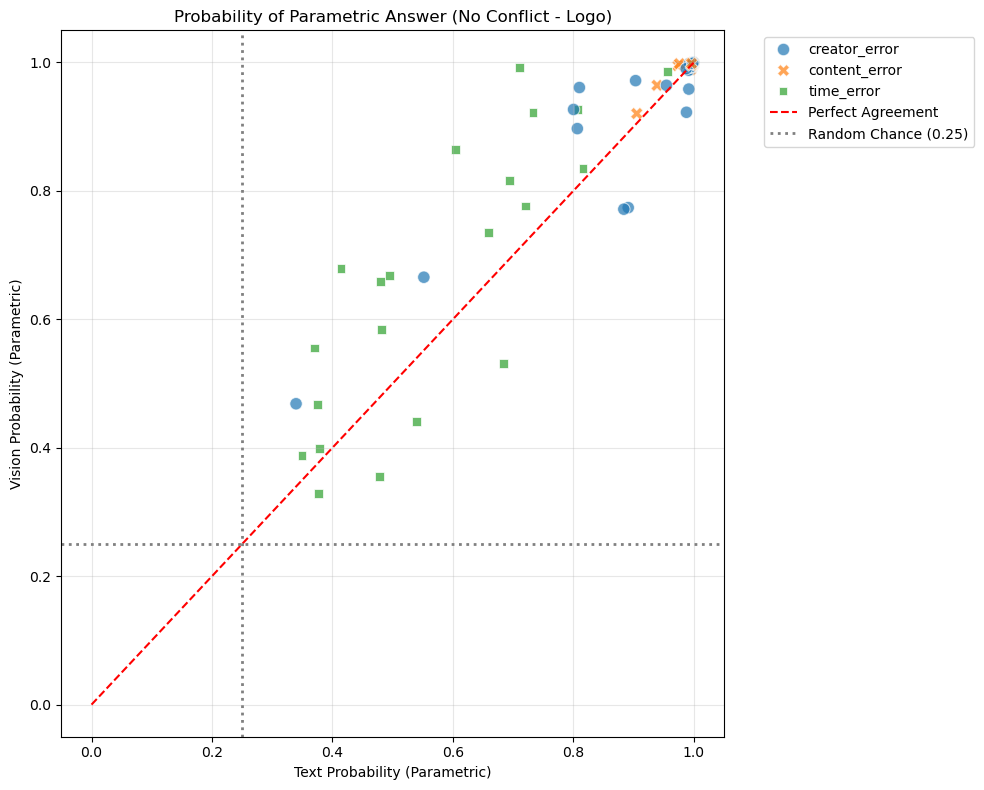

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function to extract the probability of the ground truth answer
def get_parametric_prob(row):
    return row[f"Prob_{row['Ground_Truth']}"]

# 1. Prepare the data
plot_df = pd.DataFrame({
    'Category': df_lang['Category'],
    'Text_Prob': df_lang.apply(get_parametric_prob, axis=1),
    'Vision_Prob': df_vis.apply(get_parametric_prob, axis=1)
})

# 2. Create the Scatter Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=plot_df,
    x='Text_Prob',
    y='Vision_Prob',
    hue='Category',
    style='Category',
    s=80,
    alpha=0.7
)

# 3. Add lines
# Diagonal reference (Perfect Agreement)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfect Agreement')

# Random Chance Baselines (0.25)
plt.axvline(x=0.25, color='gray', linestyle=':', linewidth=2, label='Random Chance (0.25)')
plt.axhline(y=0.25, color='gray', linestyle=':', linewidth=2)

plt.title('Probability of Parametric Answer (No Conflict - Logo)')
plt.xlabel('Text Probability (Parametric)')
plt.ylabel('Vision Probability (Parametric)')

# 4. Final Formatting
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='-', alpha=0.3)
plt.tight_layout()

plt.show()